# Eeg Signal Data Analysis

* El trabajo se inicia con la _**identificación y análisis**_ de las distintas _**fases**_ del protocolo.
* Luego se realiza un _**análisis de las frecuencias**_. Sin conclusiones.
* Por lo cual, se avanza en un análisis de los datos, con el objetivo de evaluar la performance de _**algoritmos de clustering**_ en la identificación de eventos (tos, respiración, blinks, etc)
* Para eso, se decide aislar las porciones del dataset donde los datos se encuentran por debajo de 0. Intuyendo que, al detectar estos _**"semi-eventos"**_, con un agregado de lógica, se podría identificar el evento completo.
* Se elabora un dataset donde cada registro contiene un _**semi-evento caracterizado por su duración, cantidad de registros que abarca y el valor mínimo de eeg alcanzado**_.
* Este dataset es presentado a diversos algoritmos de clustering. Varios obtienen un _**buen indicador Silhouette**_. Sin embargo, cuando se grafican los datos, se puede observar que, si bien _**algunos algoritmos logran separar bastante bien los semi-eventos**_, aún resta tuneo de hiperparámetros y búsqueda de otros algoritmos. Llegamos a una primer aproximación.
* Según nuestra evaluación, el algoritmo que mejor logra separar los clusters es el _**DBSCAN**_.

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import time
from datetime import datetime
from datetime import timedelta

## Data Load

In [5]:
signals = pd.read_csv('./data/eeg.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])
signals[:10]

timestamp  counter  eeg  attention  meditation  blinking
0  1.655925e+09       68   32          0           0         0
1  1.655925e+09       69   40          0           0         0
2  1.655925e+09       70   42          0           0         0
3  1.655925e+09       71   34          0           0         0
4  1.655925e+09       72   24          0           0         0
5  1.655925e+09       73   28          0           0         0
6  1.655925e+09       74   34          0           0         0
7  1.655925e+09       75   35          0           0         0
8  1.655925e+09       76   25          0           0         0
9  1.655925e+09       77   22          0           0         0

## Identificación de las Fases del Protocolo en los datos
Se realizó esta primer segmentación de los datos para analizar visualmente los distintos "eventos" (tos, respiración, blinks, etc) y su pattern o "dibujo" en la señal. Para entender si tenían alguna forma distintiva.

In [5]:
# Análisis General
print('timestamp ini:', signals.timestamp[0])
print('timestamp end:', signals.timestamp[339300])
print('diferencia en segundos:', signals.timestamp[339300]-signals.timestamp[0])
print('diferencia en hertz:', (signals.timestamp[339300]-signals.timestamp[0])*512)
print('hertz en 1 minuto:', 512*60)
print('minutos calculados en base a timestamp:', round((signals.timestamp[339300]-signals.timestamp[0])/60, 2))
print('minutos calculados en base a cantidad de registros:', round(signals.shape[0]/512/60, 2))

timestamp ini: 1655924764.97
timestamp end: 1655925424.92
diferencia en segundos: 659.9500000476837
diferencia en hertz: 337894.40002441406
hertz en 1 minuto: 30720
minutos calculados en base a timestamp: 11.0
minutos calculados en base a cantidad de registros: 11.04


El Timestamp (ts) del video no coincide con el ts de los datos.<br>
Hay un problema (natural) de sincronicidad (imposible comenzar a grabar el video en el mismo ts que grabar los datos) y algún tema de locale.
A continuación se analiza esta situación. <br>

La conclusiones son:
* Los datos comienzan aprox 8 seg después del inicio del video. --> para identificar el inicio de una nueva fase en los datos se deben buscar en la señal los blinks iniciales.
* En los datos, el campo "timestamp" no es unívoco. La única manera de identificar un registro es con el índice del dataframe.


In [6]:
# Se intenta convertir los ts a fecha, resolviendo problemas de locale:
# Source: https://stackoverflow.com/questions/9637838/convert-string-date-to-timestamp-in-python
def get_ts_utc(ts_str):
    # Ts de inicio del video: '2022-06-22 20:05:56.629839'
    #ts_str = '2022-06-22 20:05:56,629839'

    # pytz.all_timezones 'Europe/London'
    # naive datetime
    d = datetime.strptime(ts_str, "%Y-%m-%d %H:%M:%S,%f")
    # add proper timezone
    pst = pytz.timezone('Europe/London')
    d = pst.localize(d)
    # convert to UTC timezone
    utc = pytz.UTC
    d = d.astimezone(utc)
    # epoch is the beginning of time in the UTC timestamp world
    epoch = datetime(1970,1,1,0,0,0,tzinfo=pytz.UTC)

    # get the total second difference
    ts_ = (d - epoch).total_seconds()
    return ts_
# Source: https://stackoverflow.com/questions/9637838/convert-string-date-to-timestamp-in-python
import pytz
# Ts de inicio del video: '2022-06-22 20:05:56.629839'
time_video = '2022-06-22 20:05:56,629839'

# pytz.all_timezones 'Europe/London'
# naive datetime
d = datetime.strptime(time_video, "%Y-%m-%d %H:%M:%S,%f")
print('Fecha inicio del video sin conversión:', d)
# add proper timezone
pst = pytz.timezone('Europe/London')
d = pst.localize(d)
print('Fecha localizada.....................:', d)

# convert to UTC timezone
utc = pytz.UTC
d = d.astimezone(utc)
print('Fecha UTC............................:', d)

# epoch is the beginning of time in the UTC timestamp world
epoch = datetime(1970,1,1,0,0,0,tzinfo=pytz.UTC)

# get the total second difference
ts_ini_video = (d - epoch).total_seconds()
print('Inicio del video....:', d)
print('Inicio de los datos.:', datetime.utcfromtimestamp(signals.timestamp[0]).strftime('%Y-%m-%d %H:%M:%S'))
print('TS ini video:', ts_ini_video)
print('TS ini datos:', signals.timestamp[0])
print('Conclusión: los datos comienzan 8 segundos después del inicio de la grabación. NOTA: restar una hora y 8 segundos a la hora del video!')

Fecha inicio del video sin conversión: 2022-06-22 20:05:56.629839
Fecha localizada.....................: 2022-06-22 20:05:56.629839+01:00
Fecha UTC............................: 2022-06-22 19:05:56.629839+00:00
Inicio del video....: 2022-06-22 19:05:56.629839+00:00
Inicio de los datos.: 2022-06-22 19:06:04
TS ini video: 1655924756.629839
TS ini datos: 1655924764.97
Conclusión: los datos comienzan 8 segundos después del inicio de la grabación. NOTA: restar una hora y 8 segundos a la hora del video!


Para analizar las distintas fases del protocolo, inicialmente se agrega una columna con el timestamp en formato fecha. De esta manera, se pensaba que, observando el vídeo y tomando la fecha del video se podría acceder a los datos utilizando el timestamp convertivo a fecha.

En las primeras fases del protocolo se pudo aplicar esta forma de trabajo. 

Pero luego se comprueba que no recorta bien fases del protocolo posteriores. 

Con lo cual, las últimas fases directamente se utilizan los números de registro para poder filtrar las mismas.

In [7]:
# Se agrega una columna para filtrar por tiempo:
signals['time'] = pd.to_datetime(signals.timestamp, unit='s')
signals.head(5)

timestamp  counter  eeg  attention  meditation  blinking  \
0  1.655925e+09       68   32          0           0         0   
1  1.655925e+09       69   40          0           0         0   
2  1.655925e+09       70   42          0           0         0   
3  1.655925e+09       71   34          0           0         0   
4  1.655925e+09       72   24          0           0         0   

                           time  
0 2022-06-22 19:06:04.970000128  
1 2022-06-22 19:06:04.970000128  
2 2022-06-22 19:06:04.970000128  
3 2022-06-22 19:06:04.970000128  
4 2022-06-22 19:06:04.970000128

### Fase BASELINE

ini 2022-06-22 19:06:04.970000128 end 2022-06-22 19:07:34.970000128
EL TIMESTAMP SE REPITE PARA DISTINTOS REGISTROS CONSECUTIVOS (10):


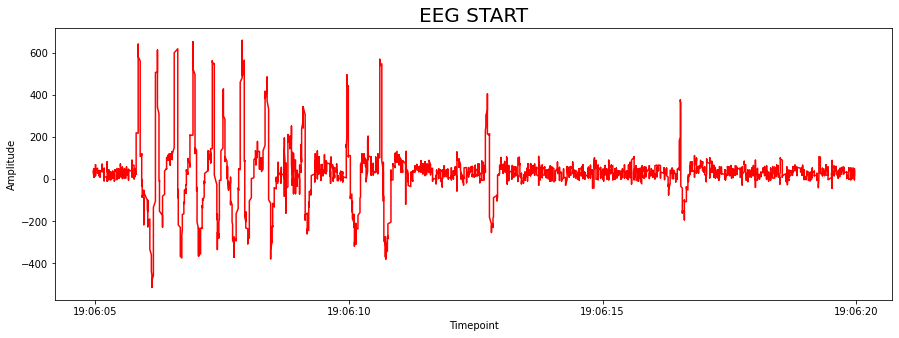

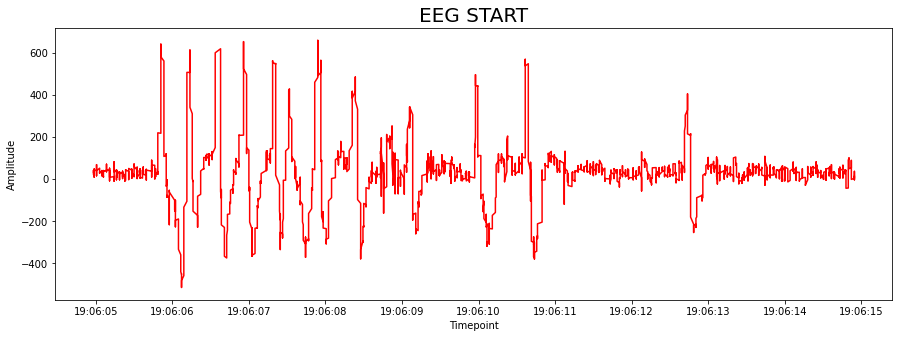

In [8]:
# 0 a 1:30 --> BASELINE
t_delta = timedelta(seconds = 60+30)
signals.time[0] + t_delta
ini = signals.time[0]
end = signals.time[0] + t_delta
print('ini', ini, 'end', end)
signals[signals.time.between(ini, end)]
############# EL TIMESTAMP SE REPITE PARA DISTINTOS REGISTROS CONSECUTIVOS:
print('EL TIMESTAMP SE REPITE PARA DISTINTOS REGISTROS CONSECUTIVOS (10):')
signals.timestamp[0], signals.timestamp[1], signals.timestamp[2], signals.timestamp[9], signals.timestamp[10]
# NOTA: hace los primeros blinks a las 20:06:06 aprox (restar 8 seg)
t_delta = timedelta(seconds = 15)
ini = signals.time[0]
end = signals.time[0] + t_delta

df_frame = signals[signals.time.between(ini, end)]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG START",size=20)
plt.show()

# Gráfica en hertz
ini_start = 0
end_start = 512*10

df_frame = signals[ini_start:end_start]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG START",size=20)
plt.show()

ini 2022-06-22 19:06:15.970000128 end 2022-06-22 19:07:10


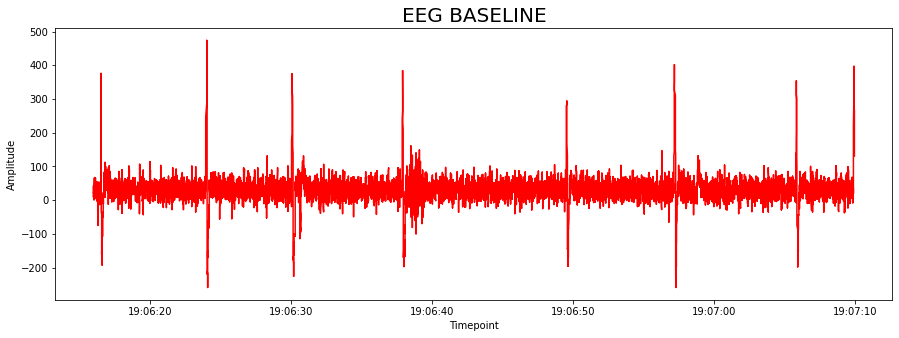

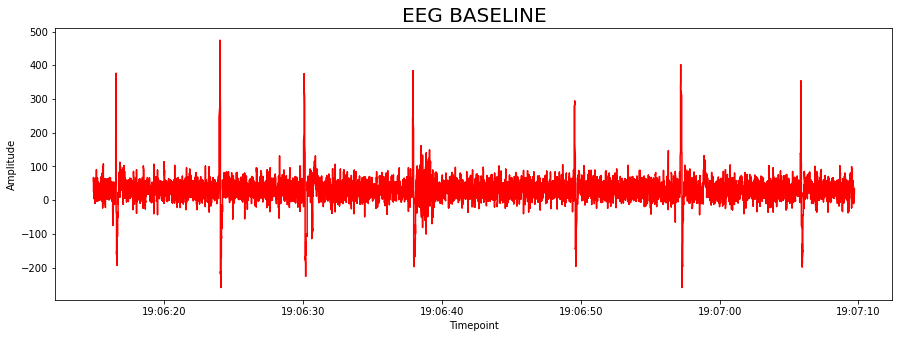

In [9]:
# NOTA: mirando el gráfico START, se toma como baseline a partir de los 11 segundos. 
# TOS comienza en 07:10:? del video con varios blinks al principio.
t_delta = timedelta(seconds = 60+24)
ini = signals.time[0] + timedelta(seconds = 11)
end = signals.time[0] + timedelta(seconds = 11) + t_delta
end = datetime(2022, 6, 22, 19, 7, 10)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
plt.figure(figsize=(15, 5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG BASELINE",size=20)
plt.show()

# Gráfica en hertz
ini_baseline = end_start
end_baseline = ini_baseline + (512*55)

df_frame = signals[ini_baseline:end_baseline]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG BASELINE",size=20)
plt.show()

# Fase TOS

ini 2022-06-22 19:07:10 end 2022-06-22 19:07:20


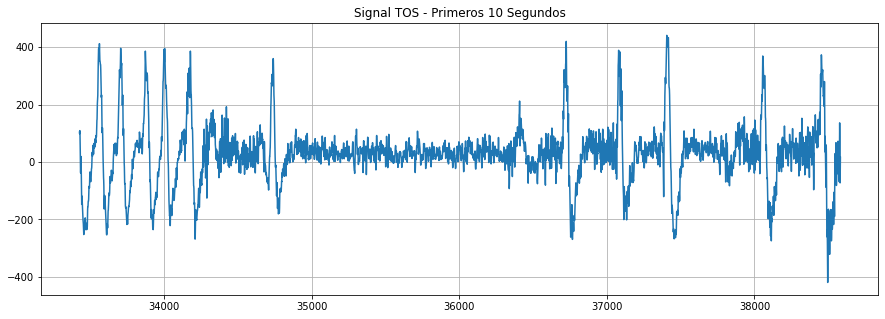

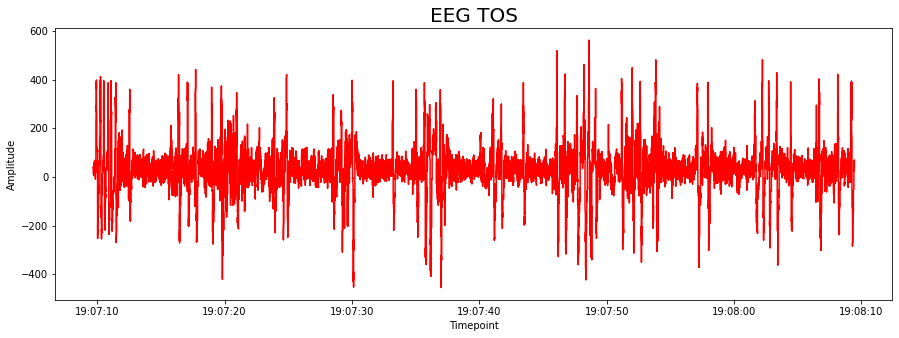

In [10]:
############# TOS
#t_delta = timedelta(seconds = 60+24)
end = signals.time[0] + timedelta(seconds = 11) + t_delta
#end = datetime(2022, 6, 22, 19, 8, 15)
t_delta = timedelta(seconds = 10)
#ini = signals.time[0] + timedelta(seconds = 11)
ini = datetime(2022, 6, 22, 19, 7, 10)
end = ini + t_delta
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]
plt.figure(figsize=(15, 5))
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal TOS - Primeros 10 Segundos')
plt.grid()
plt.show()

# Gráfica en hertz
ini_tos = end_baseline
end_tos = ini_tos + (512*60)

df_frame = signals[ini_tos:end_tos]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG TOS",size=20)
plt.show()


### Fase RESPIRACIÓN HONDA

ini 2022-06-22 19:08:14 end 2022-06-22 19:08:24


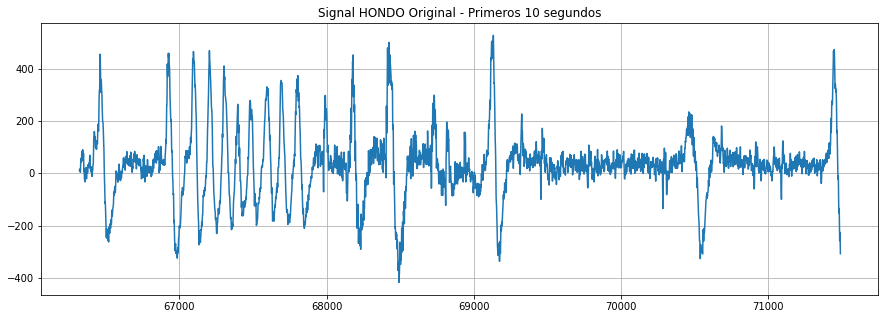

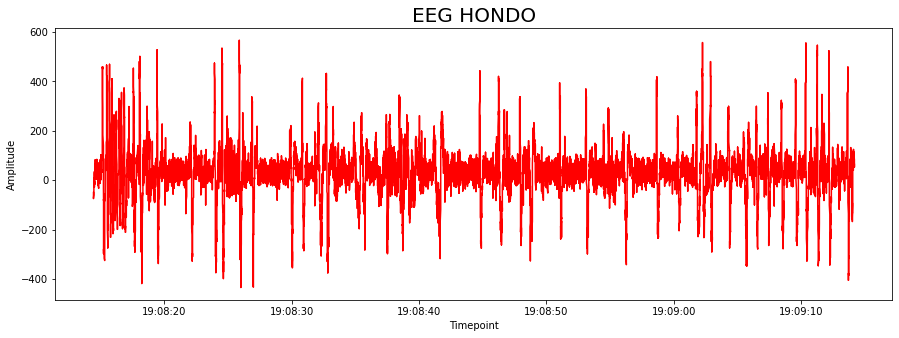

In [11]:
########### HONDO
ini = datetime(2022, 6, 22, 19, 8, 14)
end = datetime(2022, 6, 22, 19, 8, 24)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
plt.plot(df_frame.eeg)
plt.title(r'Signal HONDO Original - Primeros 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_hondo = end_tos + (512*5)
end_hondo = ini_hondo + (512*60)

df_frame = signals[ini_hondo:end_hondo]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG HONDO",size=20)
plt.show()


ini 2022-06-22 19:08:24 end 2022-06-22 19:08:34


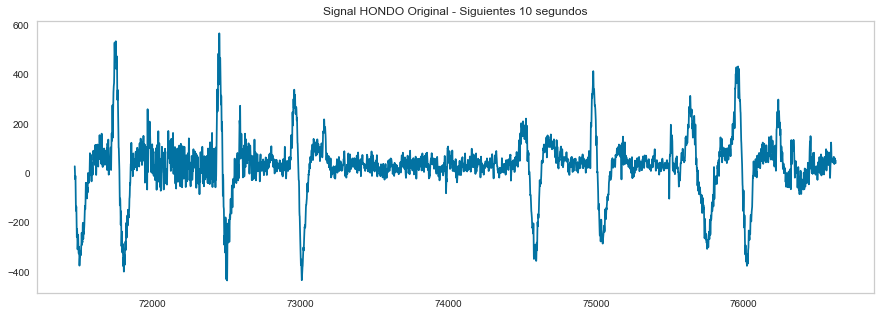

In [105]:
ini = datetime(2022, 6, 22, 19, 8, 24)
end = datetime(2022, 6, 22, 19, 8, 34)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
plt.plot(df_frame.eeg)
plt.title(r'Signal HONDO Original - Siguientes 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

### Fase RESPIRACIÓN RÁPIDA

ini 2022-06-22 19:09:16 end 2022-06-22 19:09:26


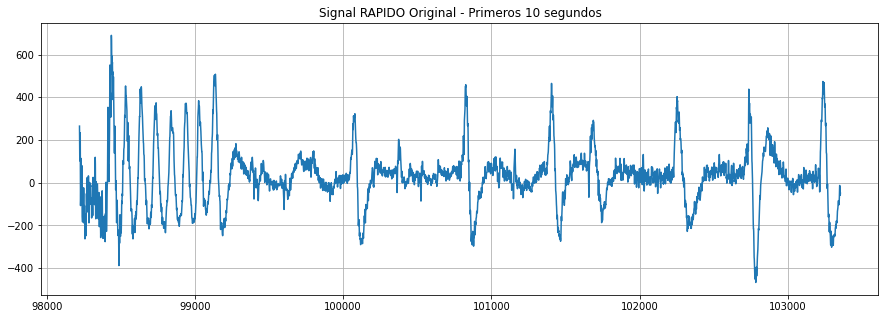

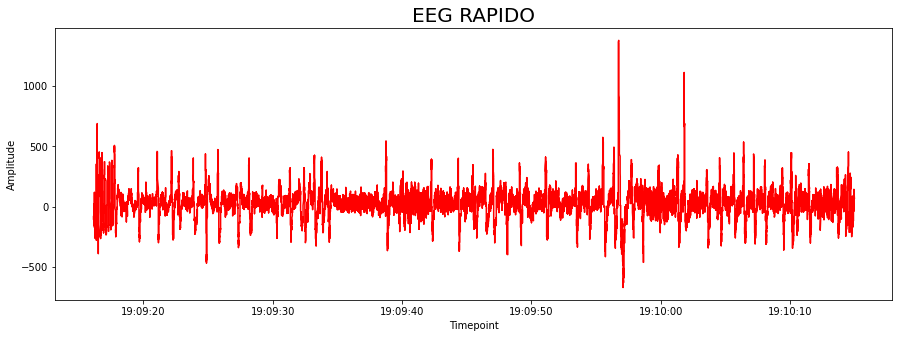

In [12]:
########### RAPIDO
ini = datetime(2022, 6, 22, 19, 9, 16)
end = datetime(2022, 6, 22, 19, 9, 26)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal RAPIDO Original - Primeros 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_rapido = end_hondo + (512*2)
end_rapido = ini_rapido + (512*59)

df_frame = signals[ini_rapido:end_rapido]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG RAPIDO",size=20)
plt.show()

ini 2022-06-22 19:09:26 end 2022-06-22 19:09:36


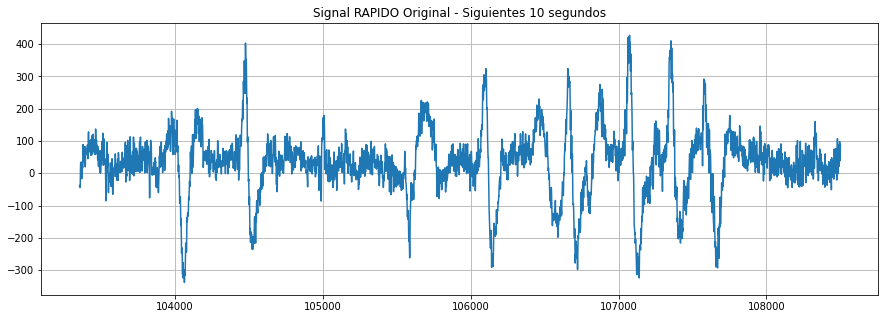

In [16]:
ini = datetime(2022, 6, 22, 19, 9, 26)
end = datetime(2022, 6, 22, 19, 9, 36)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
plt.plot(df_frame.eeg)
plt.title(r'Signal RAPIDO Original - Siguientes 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

ini 2022-06-22 19:09:36 end 2022-06-22 19:09:46


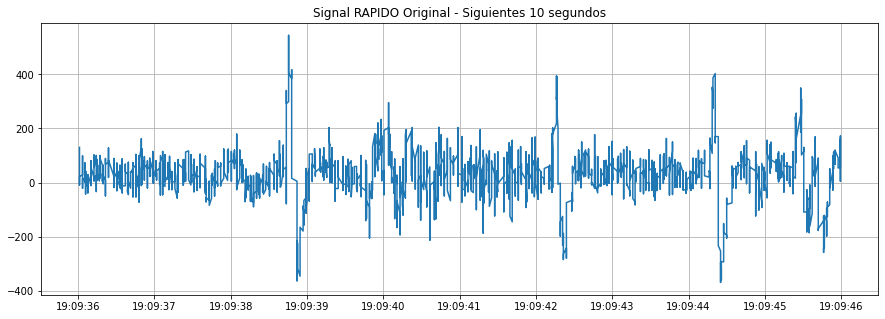

In [17]:
ini = datetime(2022, 6, 22, 19, 9, 36)
end = datetime(2022, 6, 22, 19, 9, 46)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.eeg)
plt.plot(df_frame.time, df_frame.eeg)
plt.title(r'Signal RAPIDO Original - Siguientes 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

ini 2022-06-22 19:09:40 end 2022-06-22 19:09:50


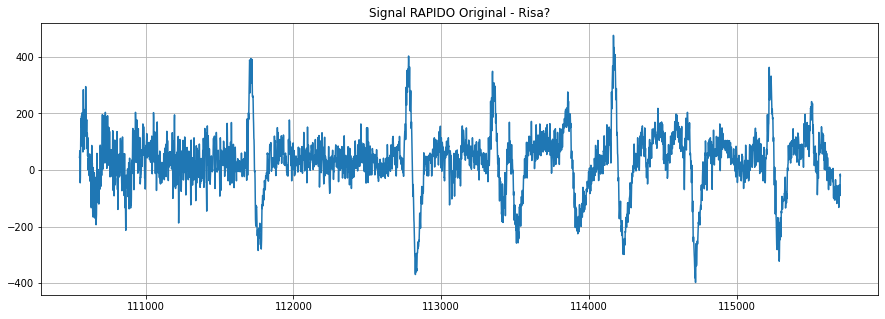

ini video: 1655924756.629839
ini data.: 1655924764.97
risa.....: 1655924980.638191
la risa debería comenzar en el período: 114692.27624511719


In [18]:
########### RAPIDO RISA
ini = datetime(2022, 6, 22, 19, 9, 40)
end = datetime(2022, 6, 22, 19, 9, 50)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
plt.plot(df_frame.eeg)
plt.title(r'Signal RAPIDO Original - Risa?')
#plt.ylim((-150, 150))
plt.grid()
plt.show()
print('ini video:', ts_ini_video)
print('ini data.:', signals.timestamp[0])
print('risa.....:', get_ts_utc('2022-06-22 20:09:40,638191'))
print('la risa debería comenzar en el período:', (get_ts_utc('2022-06-22 20:09:40,638191')-ts_ini_video)*512)

ini 2022-06-22 19:10:15 end 2022-06-22 19:10:36


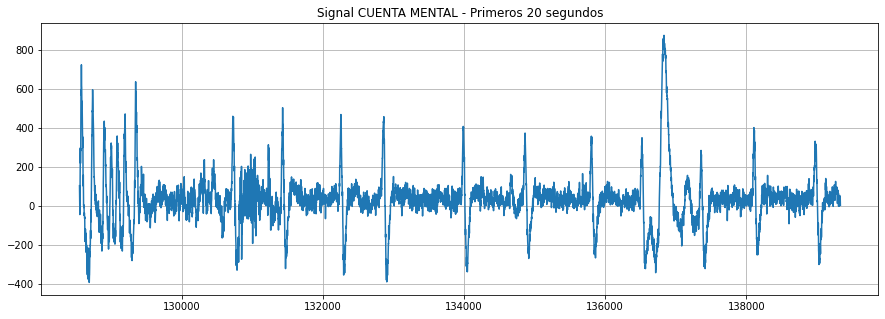

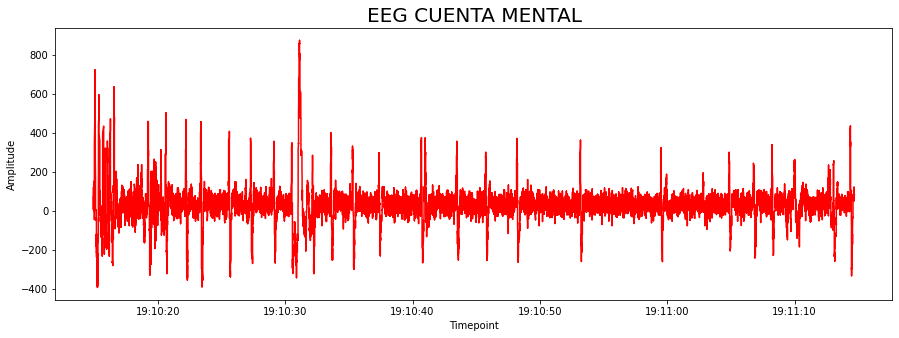

In [13]:
########### CUENTA MENTAL
ini = datetime(2022, 6, 22, 19, 10, 15)
end = datetime(2022, 6, 22, 19, 10, 36)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal CUENTA MENTAL - Primeros 20 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_cuenta = end_rapido# + (512*2)
end_cuenta = ini_cuenta + (512*60)

df_frame = signals[ini_cuenta:end_cuenta]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG CUENTA MENTAL",size=20)
plt.show()

ini 2022-06-22 19:11:15 end 2022-06-22 19:11:36


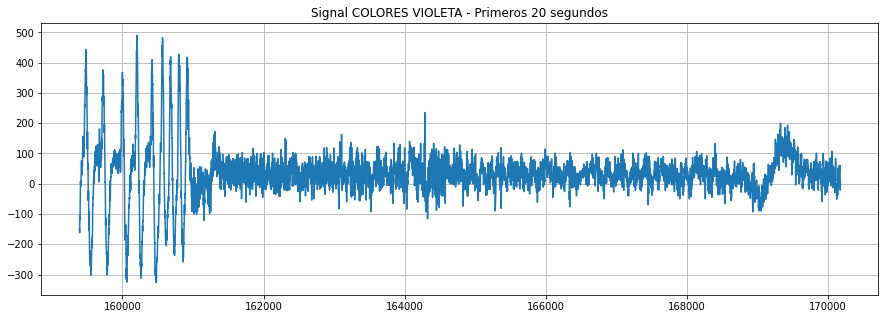

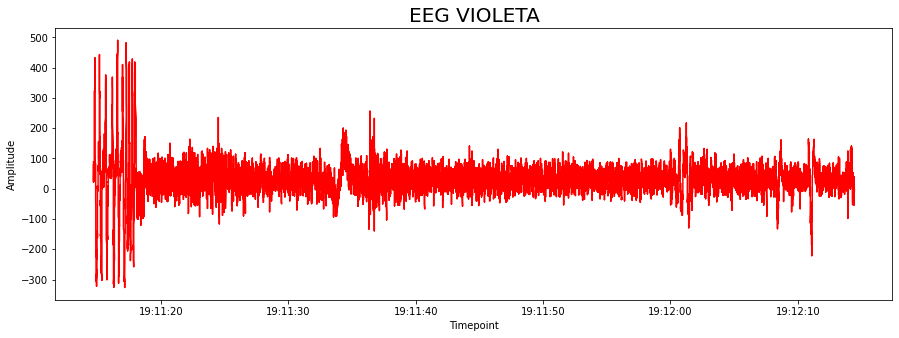

In [14]:
########### COLORES VIOLETA
ini = datetime(2022, 6, 22, 19, 11, 15)
end = datetime(2022, 6, 22, 19, 11, 36)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal COLORES VIOLETA - Primeros 20 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_violeta = end_cuenta# + (512*2)
end_violeta = ini_violeta + (512*60)

df_frame = signals[ini_violeta:end_violeta]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG VIOLETA",size=20)
plt.show()

ini 2022-06-22 19:12:15 end 2022-06-22 19:12:36


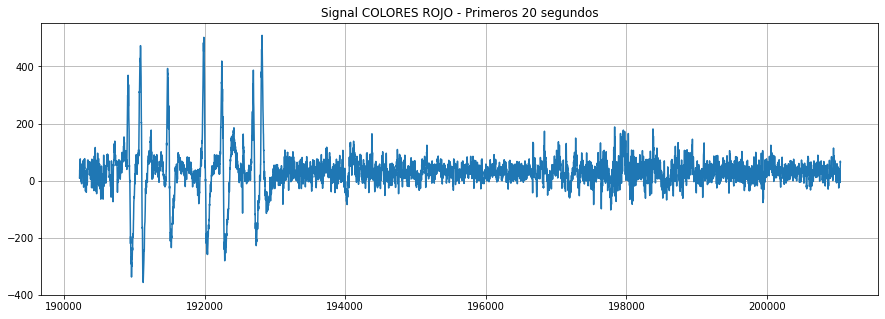

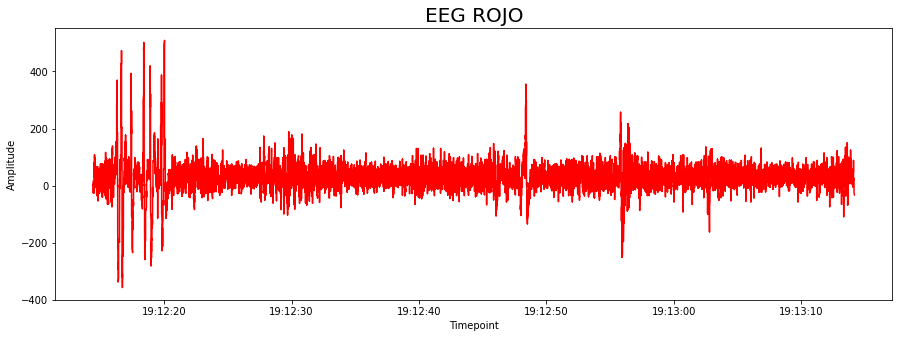

In [15]:
########### COLORES ROJO
ini = datetime(2022, 6, 22, 19, 12, 15)
end = datetime(2022, 6, 22, 19, 12, 36)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal COLORES ROJO - Primeros 20 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_rojo = end_violeta# + (512*2)
end_rojo = ini_rojo + (512*60)

df_frame = signals[ini_rojo:end_rojo]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG ROJO",size=20)
plt.show()

ini 2022-06-22 19:13:15 end 2022-06-22 19:13:36


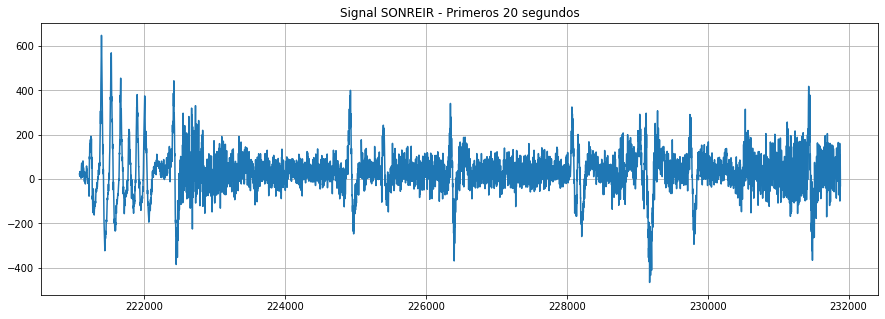

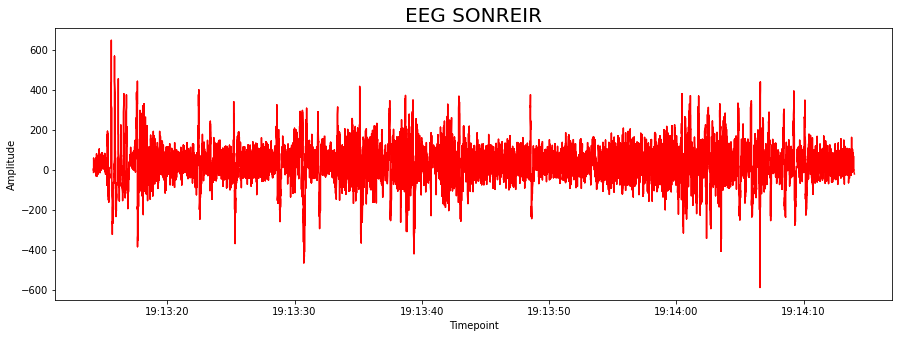

In [16]:
########### SONREIR
ini = datetime(2022, 6, 22, 19, 13, 15)
end = datetime(2022, 6, 22, 19, 13, 36)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal SONREIR - Primeros 20 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_sonreir = end_rojo# + (512*2)
end_sonreir = ini_sonreir + (512*60)

df_frame = signals[ini_sonreir:end_sonreir]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG SONREIR",size=20)
plt.show()

ini 2022-06-22 19:14:17 end 2022-06-22 19:14:47


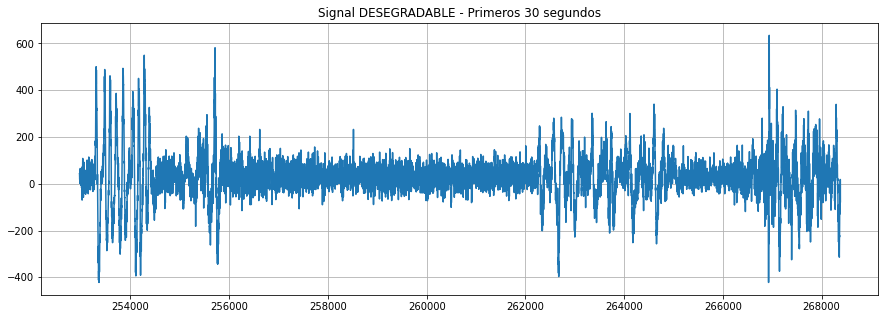

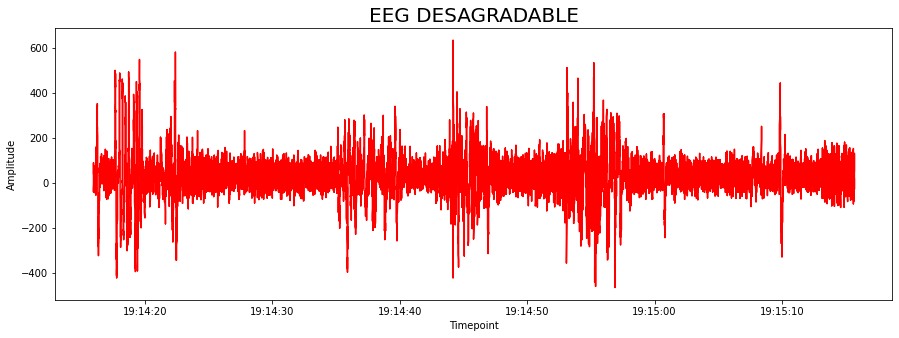

In [17]:
########### DESEGRADABLE
ini = datetime(2022, 6, 22, 19, 14, 17)
end = datetime(2022, 6, 22, 19, 14, 47)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal DESEGRADABLE - Primeros 30 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_desagradable = end_sonreir + (512*2)
end_desagradable = ini_desagradable + (512*60)

df_frame = signals[ini_desagradable:end_desagradable]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG DESAGRADABLE",size=20)
plt.show()

ini 2022-06-22 19:15:17 end 2022-06-22 19:15:46


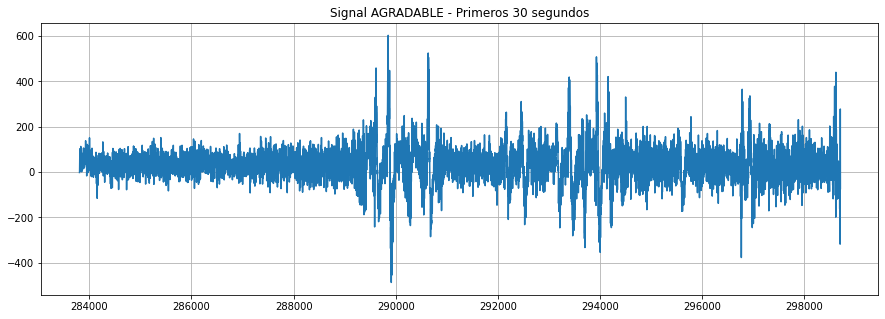

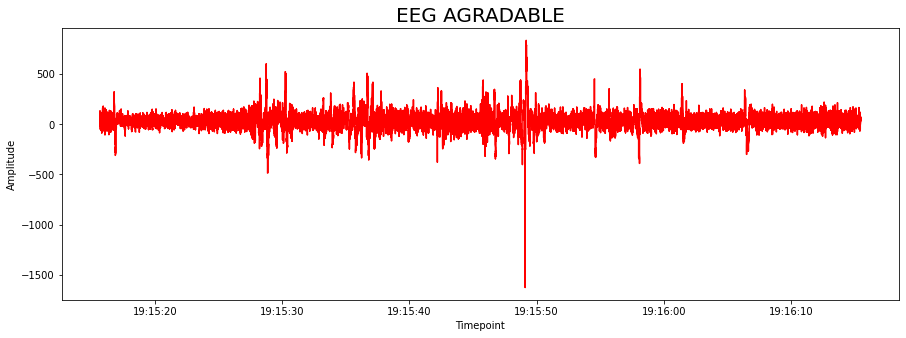

In [18]:
########### AGRADABLE - no veo que haga pestaneos al inicio
ini = datetime(2022, 6, 22, 19, 15, 17)
end = datetime(2022, 6, 22, 19, 15, 46)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal AGRADABLE - Primeros 30 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_agradable = end_desagradable# + (512*2)
end_agradable = ini_agradable + (512*60)

df_frame = signals[ini_agradable:end_agradable]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG AGRADABLE",size=20)
plt.show()

### Fase BLINKINGS

ini 2022-06-22 19:16:16 end 2022-06-22 19:16:26


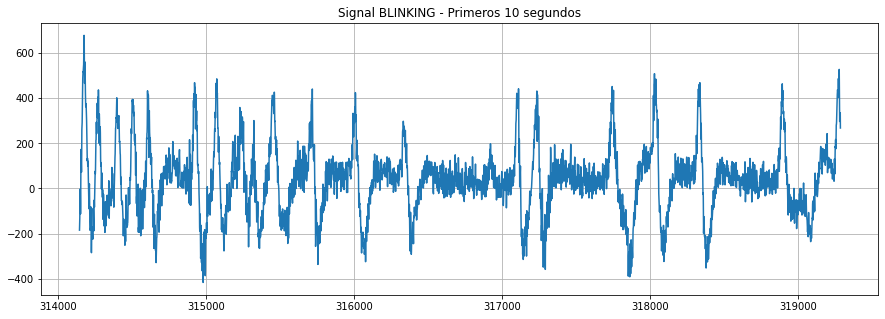

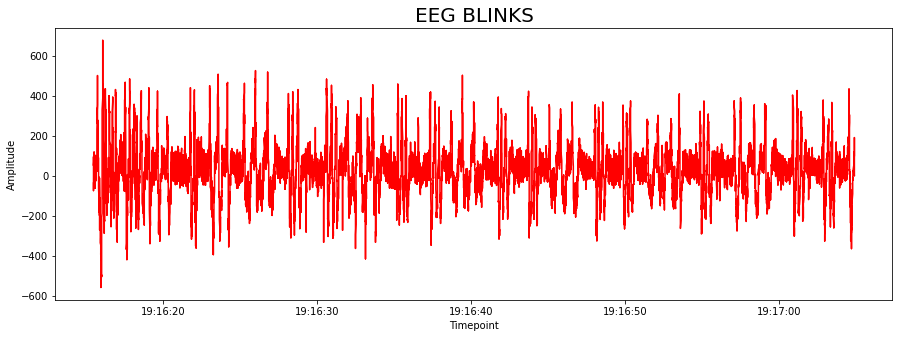

In [19]:
########### BLINKING
ini = datetime(2022, 6, 22, 19, 16, 16)
end = datetime(2022, 6, 22, 19, 16, 26)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal BLINKING - Primeros 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

# Gráfica en hertz
ini_blinks = end_agradable# + (512*2)
end_blinks = ini_blinks + (512*60)

df_frame = signals[ini_blinks:end_blinks]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG BLINKS",size=20)
plt.show()

ini 2022-06-22 19:16:26 end 2022-06-22 19:16:36


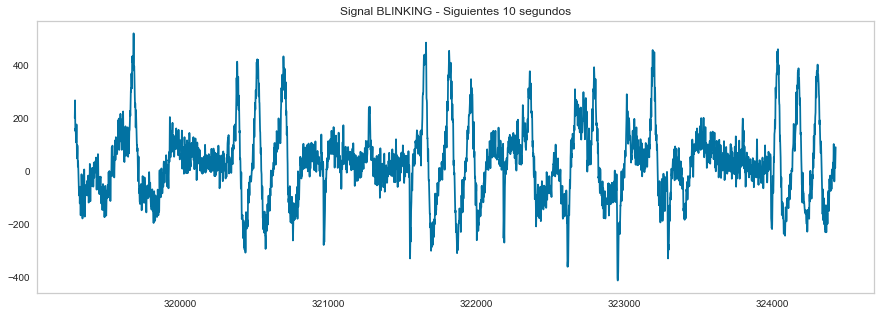

In [71]:
ini = datetime(2022, 6, 22, 19, 16, 26)
end = datetime(2022, 6, 22, 19, 16, 36)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
plt.plot(df_frame.eeg)
plt.title(r'Signal BLINKING - Siguientes 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

### Acceso a las fases utilizando la posición de inicio en el dataframe (no usa el timestamp)

ini 2022-06-22 19:16:10 end 2022-06-22 19:16:20


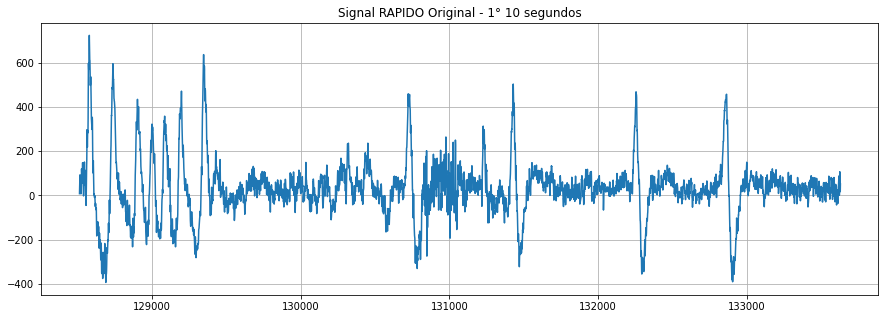

In [21]:
########### RESPIRACIÓN RAPIDA
ini_resp_rapida = 512*((60*4)+8+3) #--> pero al revisar el gráfico parece que comienza después.-
#ini = datetime(2022, 6, 22, 19, 9, 16) #16
pos_ini = ini_resp_rapida # bits dentro de 4:08 min
#end = datetime(2022, 6, 22, 19, 9, 26)
pos_end = pos_ini + (512*10)
print('ini', ini, 'end', end)

#df_frame = signals[signals.time.between(ini, end)]
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal RAPIDO Original - 1° 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

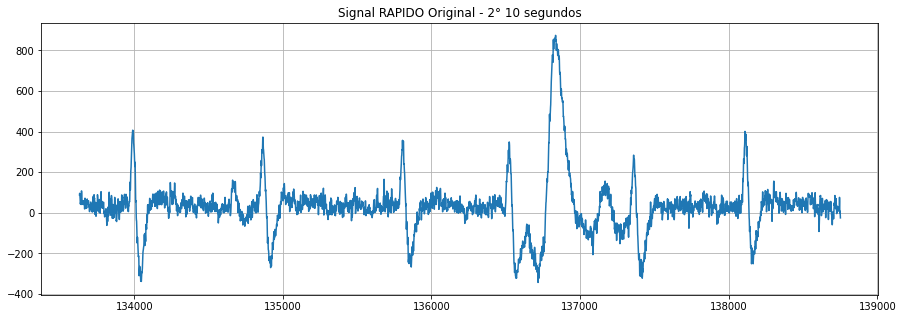

In [22]:
pos_ini = ini_resp_rapida + (512*10)
pos_end = pos_ini + (512*10)
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal RAPIDO Original - 2° 10 segundos')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

## Análisis de Frecuencias del protocolo
Se intenta realizar un análisis de frecuencias del protocolo.

Fuente: filter_spectral.py (R.Ramele)

In [8]:
from scipy.fft import rfft, rfftfreq

In [9]:
from scipy.fftpack import fft, fftfreq # Return discrete Fourier transform of real or complex sequence.
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, lfilter

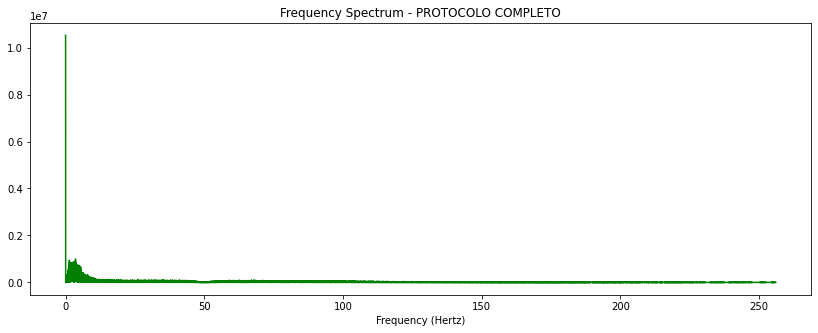

In [10]:
data = signals.values
eeg = data[:,2]
Fs = 512.0
normalized_signal = eeg
N = len(normalized_signal)
# Creo una secuencia de N puntos (el largo de EEG), de 0 hasta el largo de la secuencia en segundos (N/Fs).
x = np.linspace(0.0, int(N/Fs), N)   

yf = rfft(normalized_signal)
xf = rfftfreq(N, 1 / Fs)

plt.figure(figsize=(14,5))
plt.title('Frequency Spectrum - PROTOCOLO COMPLETO')
plt.plot(xf, np.abs(yf), color='green')
plt.xlabel('Frequency (Hertz)')
plt.show()

ini 2022-06-22 19:06:15.970000128 end 2022-06-22 19:07:10


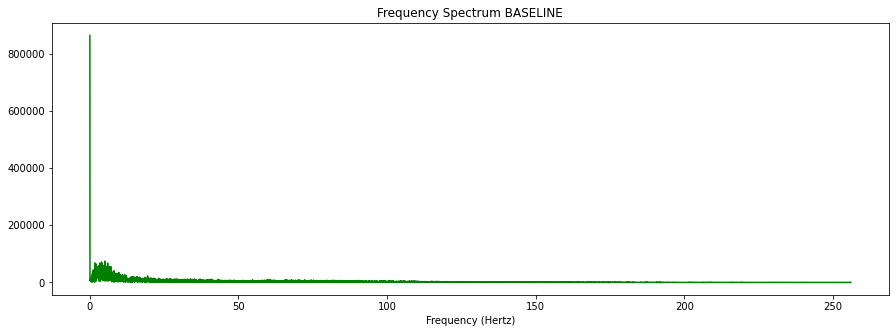

In [28]:
# Fourier de BASELINE
t_delta = timedelta(seconds = 60+24)
ini = signals.time[0] + timedelta(seconds = 11)
end = signals.time[0] + timedelta(seconds = 11) + t_delta
end = datetime(2022, 6, 22, 19, 7, 10)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]
Fs = 512.0
normalized_signal = eeg
N = len(normalized_signal)
# Creo una secuencia de N puntos (el largo de EEG), de 0 hasta el largo de la secuencia en segundos (N/Fs).
x = np.linspace(0.0, int(N/Fs), N)   
# A esa secuencia de EEG le agrego una señal pura de 30 Hz. Esto ayuda a visualizar bien que la relación espectral está ok.
#normalized_signal +=  100*np.sin(30.0 * 2.0*np.pi*x)

yf = rfft(normalized_signal)
xf = rfftfreq(N, 1 / Fs)

plt.figure(figsize=(15,5))
plt.title('Frequency Spectrum BASELINE')
plt.plot(xf, np.abs(yf), color='green')
plt.xlabel('Frequency (Hertz)')
plt.show()


ini 2022-06-22 19:07:10 end 2022-06-22 19:08:15


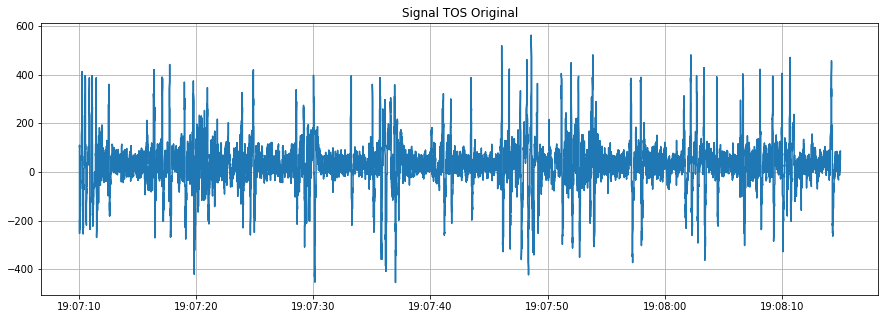

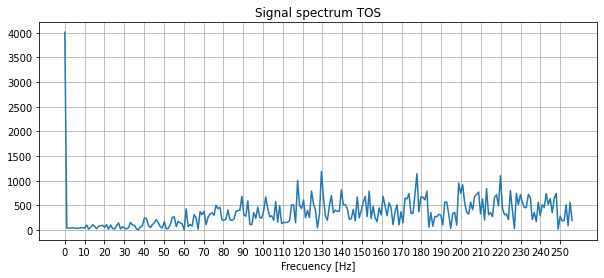

In [30]:
# Frecuencia de sampleo
N = 512.0
# sample spacing
T = 1.0 / float(N)

############# TOS
t_delta = timedelta(seconds = 60+24)
#ini = signals.time[0] + timedelta(seconds = 11)
ini = datetime(2022, 6, 22, 19, 7, 10)
end = signals.time[0] + timedelta(seconds = 11) + t_delta
end = datetime(2022, 6, 22, 19, 8, 15)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]
plt.figure(figsize=(15, 5))
plt.plot(df_frame.time, df_frame.eeg)
#lt.plot(df_frame.eeg)
plt.title(r'Signal TOS Original')
plt.grid()
plt.show()

yf = fft(df_frame.eeg)
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

plt.figure(figsize=(10, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.grid()
plt.title(r'Signal spectrum TOS')
#plt.axis((0,60,0,9))
plt.xlabel('Frecuency [Hz]')
plt.xticks(ticks=[x for x in range(0, 260, 10)])
plt.show()

#### En la Fase de TOS, se filtran las frecuencias bajas, menores a 40 Hz

In [31]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [32]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

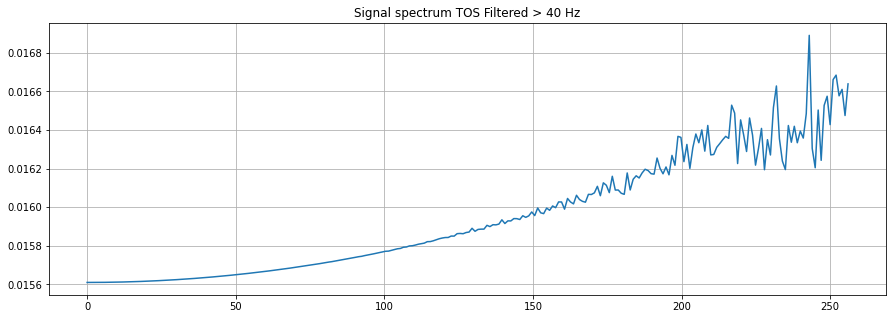

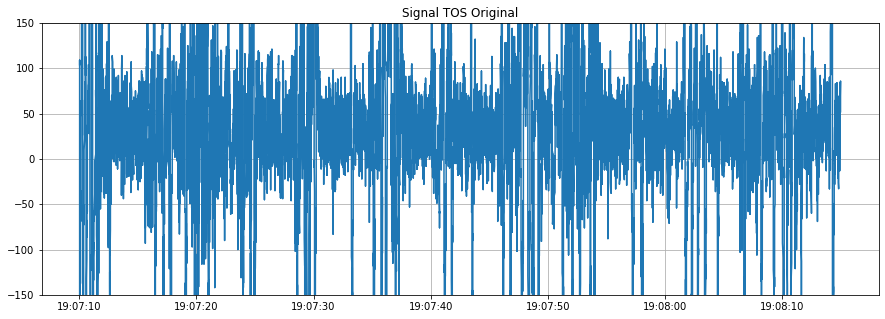

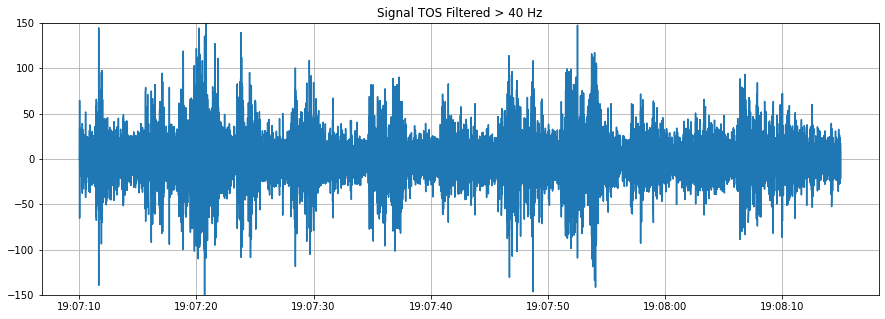

In [33]:
y = butter_bandpass_filter(eeg, 40.0, 250.0, 512.0, order=6)
yf = fft(y) # Return discrete Fourier transform of real or complex sequence.
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

plt.figure(figsize=(15, 5))
plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.title(r'Signal spectrum TOS Filtered > 40 Hz')
#plt.axis((0,60,0,1))
plt.grid()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(df_frame.time, df_frame.eeg)
plt.title(r'Signal TOS Original')
plt.ylim((-150, 150))
plt.grid()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(df_frame.time, y)
plt.title(r'Signal TOS Filtered > 40 Hz')
plt.ylim((-150, 150))
#plt.axis((0,60,0,1))
plt.grid()
plt.show()


ini 2022-06-22 19:08:14 end 2022-06-22 19:09:14


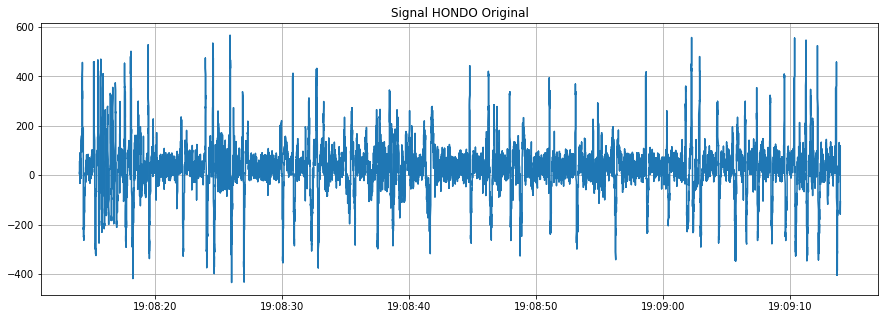

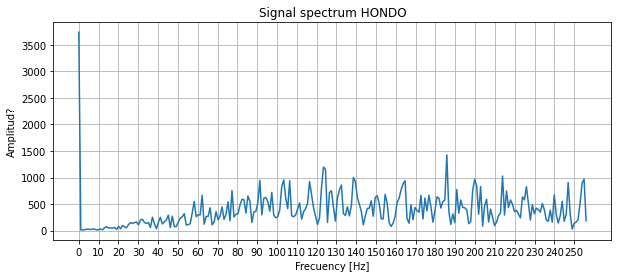

In [34]:
########### HONDO
ini = datetime(2022, 6, 22, 19, 8, 14)
end = datetime(2022, 6, 22, 19, 9, 14)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
plt.plot(df_frame.time, df_frame.eeg)
#lt.plot(df_frame.eeg)
plt.title(r'Signal HONDO Original')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

#data = df_frame.values
#eeg = data[:,2]
yf = fft(df_frame.eeg)
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

plt.figure(figsize=(10, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.grid()
plt.title(r'Signal spectrum HONDO')
#plt.axis((0,60,0,9))
plt.xlabel('Frecuency [Hz]')
plt.ylabel('Amplitud?')
plt.xticks(ticks=[x for x in range(0, 260, 10)])
plt.show()

ini 2022-06-22 19:09:14 end 2022-06-22 19:10:14


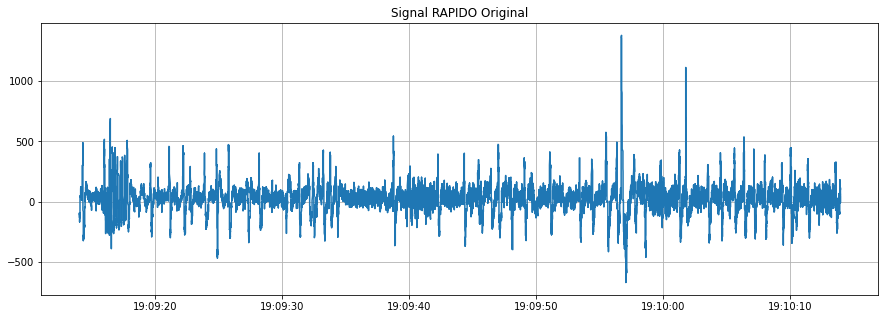

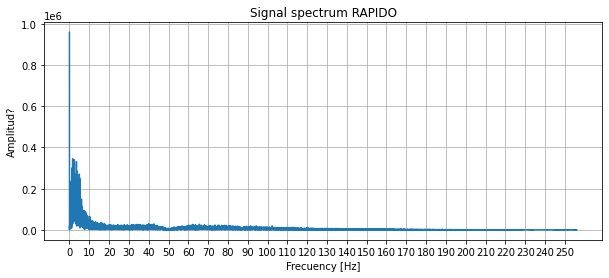

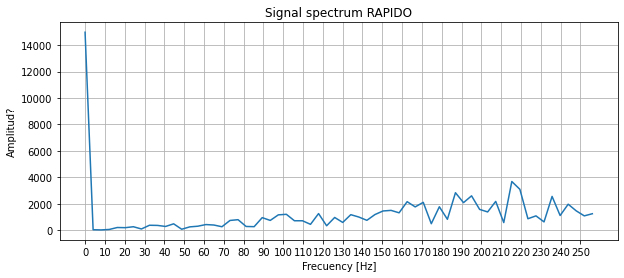

In [35]:
ini = datetime(2022, 6, 22, 19, 9, 14)
end = datetime(2022, 6, 22, 19, 10, 14)
print('ini', ini, 'end', end)

df_frame = signals[signals.time.between(ini, end)]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
plt.plot(df_frame.time, df_frame.eeg)
plt.title(r'Signal RAPIDO Original')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

#data = df_frame.values
#eeg = data[:,2]
N = len(df_frame.eeg)
yf = rfft(df_frame.eeg)
xf = rfftfreq(N, 1 / Fs)

plt.figure(figsize=(10, 4))
#plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.plot(xf, np.abs(yf))
plt.grid()
plt.title(r'Signal spectrum RAPIDO')
#plt.axis((0,60,0,9))
plt.xlabel('Frecuency [Hz]')
plt.ylabel('Amplitud?')
plt.xticks(ticks=[x for x in range(0, 260, 10)])
plt.show()

N = 128 #--------------> Esta N reduce las frecuencias que se grafican?
yf = fft(df_frame.eeg)
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))
plt.figure(figsize=(10, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.grid()
plt.title(r'Signal spectrum RAPIDO')
#plt.axis((0,60,0,9))
plt.xlabel('Frecuency [Hz]')
plt.ylabel('Amplitud?')
plt.xticks(ticks=[x for x in range(0, 260, 10)])
plt.show()

### Comparación de forma y duración de distintos eventos

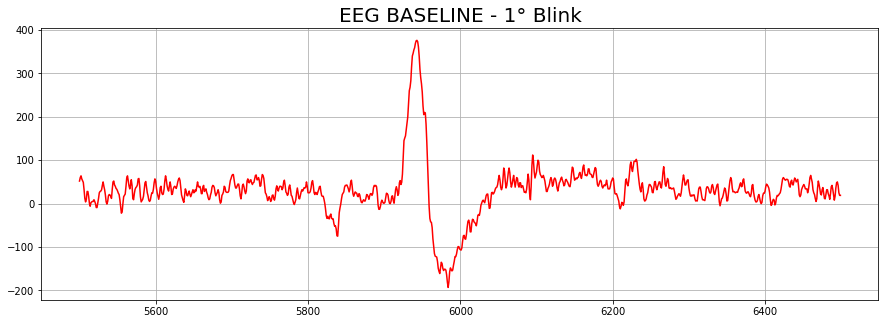

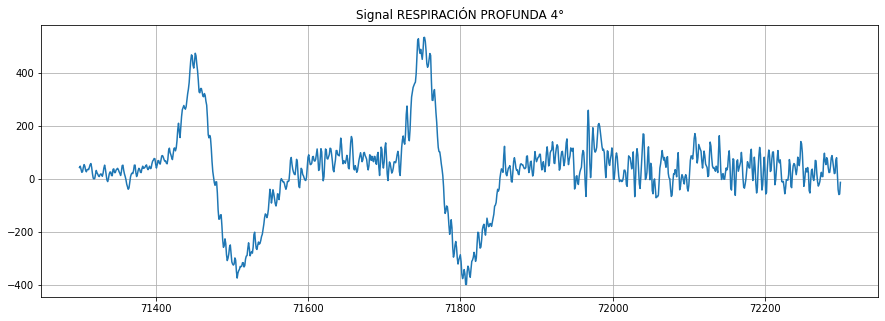

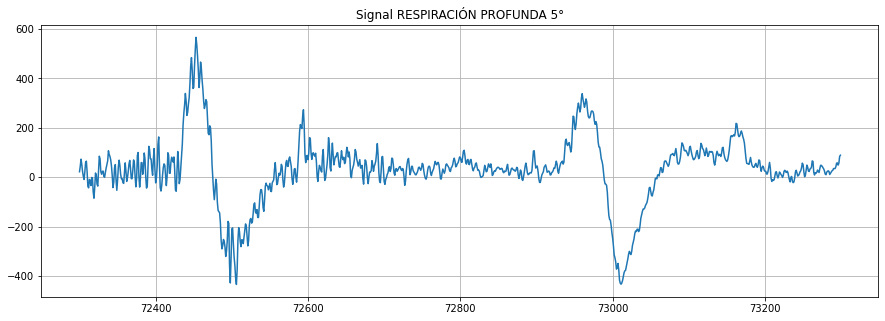

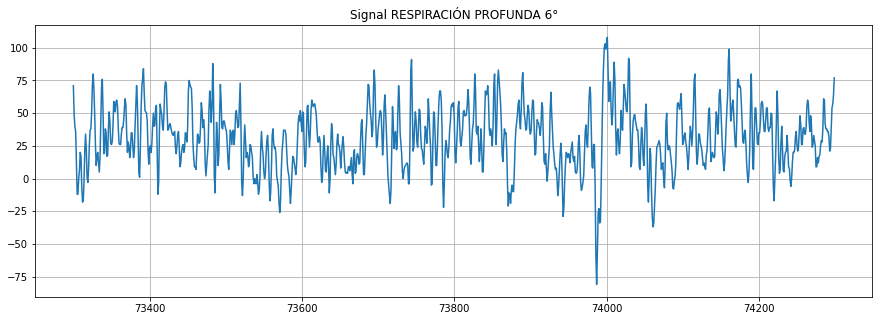

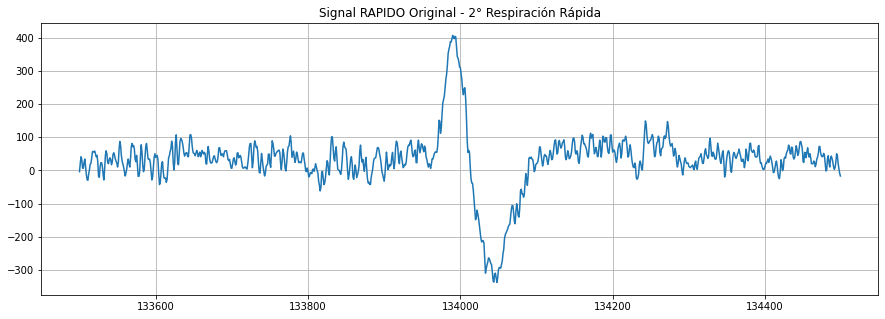

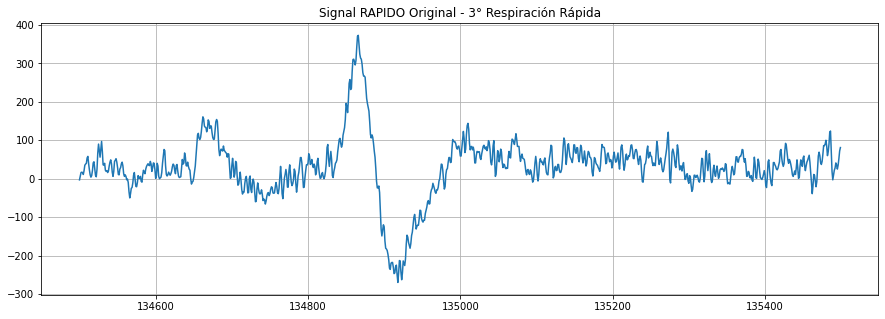

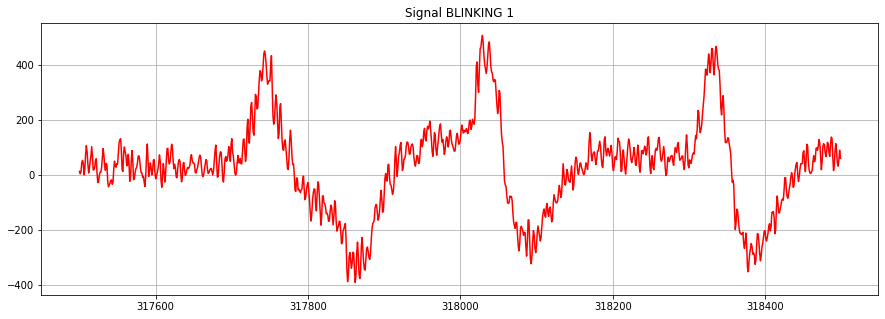

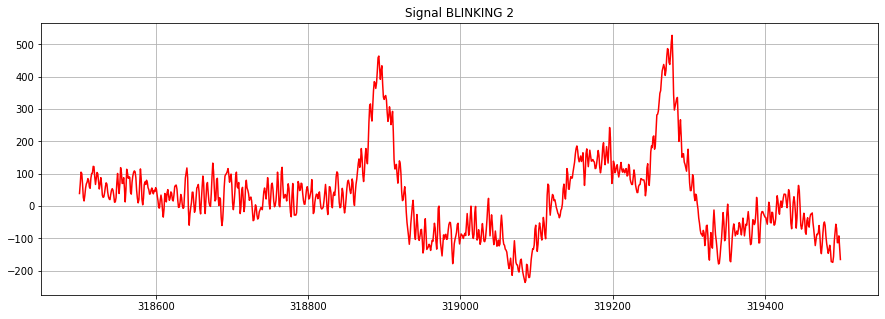

In [36]:
################## BLINK
#ini = signals.time[0] + timedelta(seconds = 11)
#end = datetime(2022, 6, 22, 19, 6, 20)
#print('ini', ini, 'end', end)
#df_frame = signals[signals.time.between(ini, end)]

pos_ini = 5500
pos_end = 6500
df_frame = signals[pos_ini: pos_end]

plt.figure(figsize=(15, 5))
#plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.plot(df_frame.eeg, color="red")
#plt.ylabel("Amplitude",size=10)
#plt.xlabel("Timepoint",size=10)
plt.title("EEG BASELINE - 1° Blink",size=20)
plt.grid()
plt.show()

########### RESPIRACIÓN PROFUNDA
#ini_resp_prof = 512*((60*2)+30)
ini_resp_prof = 66800
pos_ini = 71300
pos_end = 72300 #ini_resp_prof + (512*10)
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal RESPIRACIÓN PROFUNDA 4°')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

pos_ini = 72300
pos_end = 73300 #ini_resp_prof + (512*10)
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal RESPIRACIÓN PROFUNDA 5°')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

pos_ini = 73300
pos_end = 74300 #ini_resp_prof + (512*10)
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal RESPIRACIÓN PROFUNDA 6°')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

########### RESPIRACIÓN RÁPIDA
ini_resp_rapida = 512*((60*4)+8+3)
pos_ini = 133500
pos_end = 134500
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal RAPIDO Original - 2° Respiración Rápida')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

pos_ini = 134500
pos_end = 135500
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg)
plt.title(r'Signal RAPIDO Original - 3° Respiración Rápida')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

########### BLILNKING FINAL
pos_ini = 317500
pos_end = 318500
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg, color= 'red')
plt.title(r'Signal BLINKING 1')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

pos_ini = 318500
pos_end = 319500
df_frame = signals[pos_ini: pos_end]
data = df_frame.values
eeg = data[:,2]

plt.figure(figsize=(15, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(df_frame.eeg, color= 'red')
plt.title(r'Signal BLINKING 2')
#plt.ylim((-150, 150))
plt.grid()
plt.show()


## Identificación de Eventos
Del análisis visual de eventos como la respiración y los blinks, se intuye que puede ser posible identificar un evento identificándo en los datos los períodos en que la señal toma valores menores a 0 (se identifica una parte del evento, lo que luego podría permitir identificar el resto del evento, agregando lógica)

Siguiendo esta intuición, se analiza el dataset completo, armando un segundo dataset con los datos de cada semi-evento (timestamp inicio, timestamp fin, duración, valor mínimo de la señal, cantidad de registros = "bits")

Cada registro de este nuevo dataset corresponderá a un semi-evento. Este nuevo dataset luego se lo expone a algoritmos de clustering para ver la capacidad de los mismos de identificar semi-eventos característicos.

Dados los resultados dispares de los algoritmos de clustering (identificación de muchos o pocos clusters, pero en ningún caso 11 clusters -10 fases del protocolo, exceptuando baseline + un cluster para todo lo que no sea un semi-evento), se probaron los algoritmos de clustering sobre fases específicas del protocolo.

In [6]:
ini_start = 0
end_start = 512*10
ini_baseline = end_start
end_baseline = ini_baseline + (512*55)
ini_tos = end_baseline
end_tos = ini_tos + (512*60)
ini_hondo = end_tos + (512*5)
end_hondo = ini_hondo + (512*60)
ini_rapido = end_hondo + (512*2)
end_rapido = ini_rapido + (512*59)
ini_cuenta = end_rapido# + (512*2)
end_cuenta = ini_cuenta + (512*60)
ini_violeta = end_cuenta# + (512*2)
end_violeta = ini_violeta + (512*60)
ini_rojo = end_violeta# + (512*2)
end_rojo = ini_rojo + (512*60)
ini_sonreir = end_rojo# + (512*2)
end_sonreir = ini_sonreir + (512*60)
ini_desagradable = end_sonreir + (512*2)
end_desagradable = ini_desagradable + (512*60)
ini_agradable = end_desagradable# + (512*2)
end_agradable = ini_agradable + (512*60)
ini_blinks = end_agradable# + (512*2)
end_blinks = ini_blinks + (512*60)

In [7]:
# Lista con el inicio de cada frame (en timestamp)
lst_ini_frames = [ini_start, ini_baseline, ini_tos, ini_hondo, ini_rapido, ini_cuenta, ini_violeta, ini_rojo, ini_sonreir, ini_desagradable
                , ini_agradable, ini_blinks]

lst_frames_name = ['START', 'BASELINE', 'TOS', 'HONDO', 'RAPIDO', 'CUENTA MENTAL', 'COLORES VIOLETA', 'COLORES ROJO', 'SONREIR', 'DESEGRADABLE'
                , 'AGRADABLE', 'BLINKING']
print(len(lst_ini_frames), len(lst_frames_name))

12 12


In [8]:
# Armado del nuevo dataset
lst_eventos = []
idx = 0
eeg_ant = signals.loc[idx].eeg
while 0 <= idx < len(signals):
    row = signals.loc[idx]    
    #if 69050 < idx < 69300:
    if True:
        # Si cruza el 0 desde arriba
        if eeg_ant >= 0 and row.eeg < 0:
            evento = [row.timestamp]
            pos_ini = idx
            eeg_min = row.eeg
            bits = 1
            idx +=1
            row = signals.loc[idx]
            while row.eeg < 0:
                bits +=1
                eeg_min = row.eeg if row.eeg < eeg_min else eeg_min
                idx +=1
                row = signals.loc[idx]
            frame = ''
            for i in range(0, len(lst_ini_frames)):
                if i==len(lst_ini_frames)-1 and pos_ini >= lst_ini_frames[i]:
                    frame = lst_frames_name[i]
                    break
                elif pos_ini >= lst_ini_frames[i] and pos_ini <= lst_ini_frames[i+1]:
                    frame = lst_frames_name[i]
                    break
            if frame == '':
                frame = 'UNKNOWN'
            evento.extend([row.timestamp, pos_ini, idx, bits, eeg_min, frame])
            lst_eventos.append(evento)
        else:
            idx +=1
    else:
        idx +=1
    eeg_ant = row.eeg
df_eventos = pd.DataFrame(data=lst_eventos, columns=['ts_ini', 'ts_end', 'pos_ini', 'pos_end', 'bits', 'eeg_min', 'frame'])
df_eventos['duration'] = df_eventos.ts_end - df_eventos.ts_ini
print(len(lst_eventos))
df_eventos.head(5)

15297


ts_ini        ts_end  pos_ini  pos_end  bits  eeg_min  frame  \
0  1.655925e+09  1.655925e+09      116      119     3     -8.0  START   
1  1.655925e+09  1.655925e+09      122      125     3    -10.0  START   
2  1.655925e+09  1.655925e+09      155      156     1     -3.0  START   
3  1.655925e+09  1.655925e+09      179      181     2     -3.0  START   
4  1.655925e+09  1.655925e+09      215      221     6     -9.0  START   

   duration  
0      0.00  
1      0.00  
2      0.00  
3      0.00  
4      0.01

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
label_encoder = LabelEncoder()
df_eventos['frame_id'] = label_encoder.fit_transform(df_eventos.frame)
df_eventos.head()

ts_ini        ts_end  pos_ini  pos_end  bits  eeg_min  frame  \
0  1.655925e+09  1.655925e+09      116      119     3     -8.0  START   
1  1.655925e+09  1.655925e+09      122      125     3    -10.0  START   
2  1.655925e+09  1.655925e+09      155      156     1     -3.0  START   
3  1.655925e+09  1.655925e+09      179      181     2     -3.0  START   
4  1.655925e+09  1.655925e+09      215      221     6     -9.0  START   

   duration  frame_id  
0      0.00        10  
1      0.00        10  
2      0.00        10  
3      0.00        10  
4      0.01        10

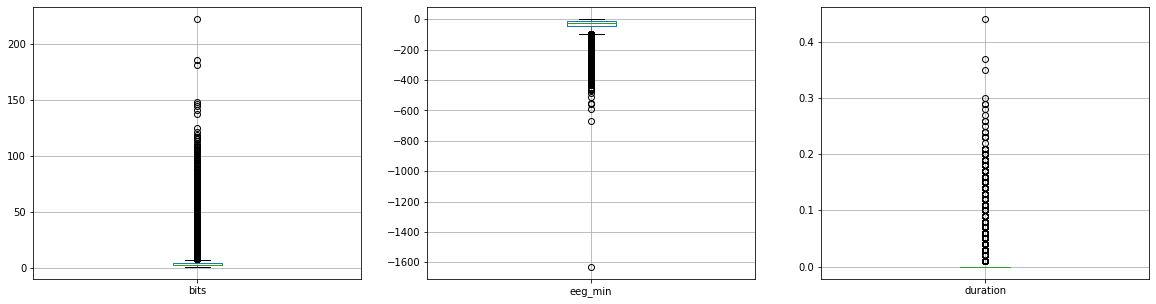

In [10]:
# Análisis del nuevo dataset con gráficos
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
df_eventos.boxplot(column=['bits'], ax=axes[0])
df_eventos.boxplot(column=['eeg_min'], ax=axes[1])
df_eventos.boxplot(column=['duration'], ax=axes[2]);

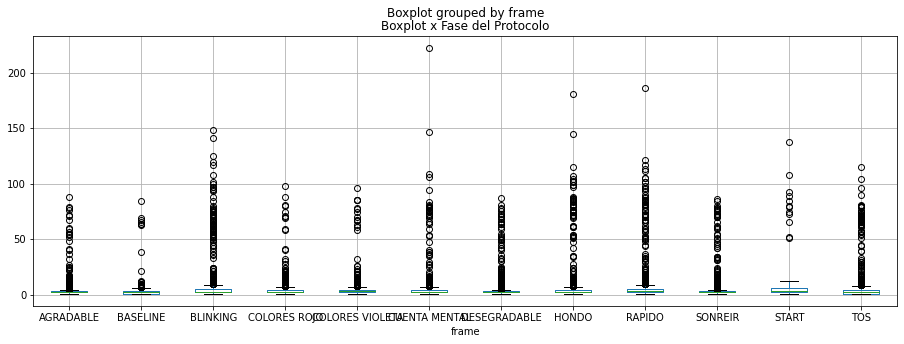

In [11]:
df_eventos.boxplot(column=['bits'], by='frame', figsize=(15, 5))
plt.title(r'Boxplot x Fase del Protocolo');
plt.show()

In [11]:
import plotly.express as px

In [13]:
#https://towardsdatascience.com/clustering-with-more-than-two-features-try-this-to-explain-your-findings-b053007d680a
fig = px.scatter_matrix(df_eventos.drop(['ts_ini', 'ts_end', 'pos_ini', 'pos_end', 'frame'], axis=1), width=800, height=600)
fig.show()

In [28]:
fig1 = px.scatter(df_eventos, x="eeg_min", y="bits", color="frame_id",
                 size="duration")
fig1.update_layout(title="4 Features Representation - Frame = color - Duration = size of bubble")
#fig1.update_xaxes(range=[-800, 0])
#fig1.update_yaxes(range=[3, 9])
fig1.show()

In [12]:
fig1 = px.scatter(df_eventos, x="eeg_min", y="bits", color="frame_id",
                 size="duration")
fig1.update_layout(title="4 Features Representation - Frame = color - Duration = size of bubble - Detail")
fig1.update_xaxes(range=[-600, 0])
#fig1.update_yaxes(range=[3, 9])
fig1.show()

In [30]:
fig2 = px.scatter_3d(df_eventos, x="eeg_min", y="bits", z="duration", color='frame_id', size="bits", width=800, height=600)
fig2.update_layout(title="5 Features Representation")
fig2.show()

In [13]:
# Cantidad de eventos por duración del evento (en cantidad de registros que contiene el evento)
df_eventos.groupby('bits').agg(cont=('ts_ini', 'count'))[:20]

cont
bits      
1     3700
2     4531
3     2846
4     1411
5      722
6      418
7      283
8      205
9      155
10     132
11      92
12      78
13      52
14      43
15      27
16      20
17      23
18      18
19      13
20      12

1655924766.27 1655924766.37
51


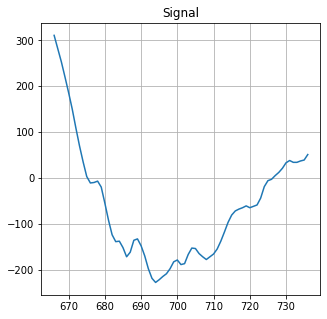

In [14]:
# Gráfico de uno de los eventos
print(df_eventos.loc[8].ts_ini, df_eventos.loc[8].ts_end)
#signals[signals.timestamp.between(df_eventos.loc[8].ts_ini, df_eventos.loc[8].ts_end)]
print(len(signals[int(df_eventos.loc[8].pos_ini):int(df_eventos.loc[8].pos_end)]))

plt.figure(figsize=(5, 5))
# Conviene graficar sin el DATE
#plt.plot(df_frame.time, df_frame.eeg)
plt.plot(signals[int(df_eventos.loc[8].pos_ini)-10:int(df_eventos.loc[8].pos_end)+10].eeg)
plt.title(r'Signal')
#plt.ylim((-150, 150))
plt.grid()
plt.show()

### Gráfico de los eventos en el dataset original

In [15]:
# Se genera un nuevo dataset que, para cada evento, contiene los registros intermedios
# se agrega una columna "flag" que marca si cada registro forma parte o no de un evento.
lst_eventos_splitted = []
for row in df_eventos.itertuples():
    evento = [[i, -1] for i in range(int(getattr(row, 'pos_ini')), int(getattr(row, 'pos_end')))]
    lst_eventos_splitted.extend(evento)
print(len(lst_eventos_splitted))
pd.DataFrame(data=lst_eventos_splitted, columns=['idx', 'flag']).set_index(keys='idx', drop=True)

# Se agrega la información de evento al dataset original:
df_eventos_splitted = pd.DataFrame(data=lst_eventos_splitted, columns=['idx', 'flag']).set_index(keys='idx', drop=True)
df_merge = signals.merge(df_eventos_splitted, how='left', left_index=True, right_index=True)
df_merge.fillna(0, inplace=True)
df_merge.head()

76928


timestamp  counter  eeg  attention  meditation  blinking  flag
0  1.655925e+09       68   32          0           0         0   0.0
1  1.655925e+09       69   40          0           0         0   0.0
2  1.655925e+09       70   42          0           0         0   0.0
3  1.655925e+09       71   34          0           0         0   0.0
4  1.655925e+09       72   24          0           0         0   0.0

In [25]:
df_frame.flag.unique()

array([ 0., -1.])

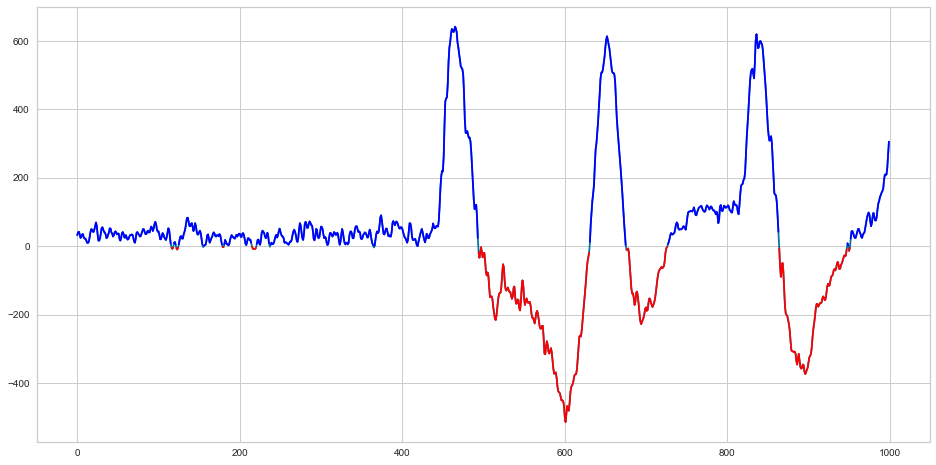

In [27]:
# https://community.dataquest.io/t/how-to-change-colour-of-a-line-plot-based-on-a-condition-below-above-average/558563/3
# Se grafica una porción de los datos
pos_ini = 0
pos_end = 1000
df_frame = df_merge[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,8))
# this line is optional - it connects plots that are below and above the hline:
plt.plot(df_frame.eeg)
plt.plot(np.where(df_frame.flag >= 0, df_frame.eeg, None), color="blue", label="1")
plt.plot(np.where(df_frame.flag < 0, df_frame.eeg, None), color="red", label="1")
#plt.axhline(df_frame.eeg.mean(), color='red')
plt.show()

# Clustering
https://www.analyticsvidhya.com/blog/2021/05/what-why-and-how-of-spectral-clustering/

Ideas a trabajar (no alcanzó el tiempo):
* Filtrar sólo los eventos que pasen un threshold y clusterizar
* Pattern recognition
    * https://stackoverflow.com/questions/11752727/pattern-recognition-in-time-series/11903770#11903770

### Evaluation metrics for clustering:
https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/

#### Silhouette Coefficient
The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

#### Dunn’s Index
Dunn’s Index is equal to the minimum inter-cluster distance divided by the maximum cluster size. Note that large inter-cluster distances (better separation) and smaller cluster sizes (more compact clusters) lead to a higher DI value. A higher DI implies better clustering. It assumes that better clustering means that clusters are compact and well-separated from other clusters.

https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/<br>
#### Calinski Harabaz Index
The higher the index the better is clustering. The Calinski Harabaz index is based on the principle of variance ratio. This ratio is calculated between two parameters within-cluster diffusion and between cluster dispersion. 

#### Davies Bouldin index
The value of this index should be small. 

# Clustering with PyCaret Package

Fuentes consultadas:
https://pycaret.gitbook.io/docs/get-started/tutorials<br>
https://github.com/pycaret/pycaret/blob/master/tutorials/Clustering%20Tutorial%20Level%20Beginner%20-%20CLU101.ipynb<br>
https://www.kaggle.com/code/kaanboke/a-gentle-intro-to-pycaret-beginner-friendly/notebook<br>

In [17]:
from pycaret.clustering import *

In [18]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors

### Clustering con el dataset de eventos completo

In [19]:
# Seteo del entorno. Se eliminan las columnas no utilizadas del dataset
exp_clu101 = setup(df_eventos, normalize = True, 
                   ignore_features = ['ts_ini', 'ts_end', 'pos_ini', 'pos_end', 'frame', 'frame_id'],
                   session_id = 123)

In [52]:
# Modelos contemplados en la librería. Todos incluidos en sklearn
models()

Name  \
ID                                            
kmeans                   K-Means Clustering   
ap                     Affinity Propagation   
meanshift             Mean Shift Clustering   
sc                      Spectral Clustering   
hclust             Agglomerative Clustering   
dbscan     Density-Based Spatial Clustering   
optics                    OPTICS Clustering   
birch                      Birch Clustering   
kmodes                   K-Modes Clustering   

                                                   Reference  
ID                                                            
kmeans                        sklearn.cluster._kmeans.KMeans  
ap         sklearn.cluster._affinity_propagation.Affinity...  
meanshift              sklearn.cluster._mean_shift.MeanShift  
sc              sklearn.cluster._spectral.SpectralClustering  
hclust     sklearn.cluster._agglomerative.AgglomerativeCl...  
dbscan                        sklearn.cluster._dbscan.DBSCAN  
optics                        sklearn.cluster._optics.OPTICS  
birch                           sklearn.cluster._birch.Birch  
kmodes                                  kmodes.kmodes.KModes

In [28]:
# De la totalidad de los algoritmos contemplados, sólo estos 7 convergen o aplican (kmodes es para datos categóricos)
# El proceso demoró 7 min
algorithms = ['meanshift', 'kmeans', 'sc', 'hclust', 'dbscan', 'optics', 'birch']
lst_performance = []
for algorithm in algorithms:
    model = create_model(algorithm)
    model_df = assign_model(model)
    results = pull()
    lst_performance.append([algorithm, results.loc[0].Silhouette, results.loc[0]['Calinski-Harabasz'], results.loc[0]['Davies-Bouldin']
            , results.loc[0]['Homogeneity'], results.loc[0]['Rand Index'], results.loc[0]['Completeness'], len(model_df.Cluster.unique())])
df_performance = pd.DataFrame(data=lst_performance, columns=['algorithm', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'homogenity'
                            , 'rand_index', 'completeness', 'num_clusters'])
df_performance

Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  Rand Index  \
0       0.883          7860.3523          0.4759            0           0   

   Completeness  
0             0

algorithm  silhouette  calinski_harabasz  davies_bouldin  homogenity  \
0  meanshift      0.5810          1951.0118          0.7837         0.0   
1     kmeans      0.6284         22851.3427          0.7254         0.0   
2         sc      0.9538           294.1344          0.0327         0.0   
3     hclust      0.5933         19760.3951          0.7327         0.0   
4     dbscan      0.7569          4433.3677          3.7957         0.0   
5     optics      0.6801            24.9265          1.3915         0.0   
6      birch      0.8830          7860.3523          0.4759         0.0   

   rand_index  completeness  num_clusters  
0         0.0           0.0            80  
1         0.0           0.0             4  
2         0.0           0.0             2  
3         0.0           0.0             4  
4         0.0           0.0             8  
5         0.0           0.0           594  
6         0.0           0.0             4

In [29]:
# Con birch no mejoran los indicadores agregando más clusters. Con kmeans, mejoran si son menos clusters
algorithm = 'kmeans'
lst_performance_2 = []
for num_cluster in range(2,4):
    model = create_model(algorithm, num_clusters=num_cluster)
    model_df = assign_model(model)
    results = pull()
    lst_performance.append([algorithm, results.loc[0].Silhouette, results.loc[0]['Calinski-Harabasz'], results.loc[0]['Davies-Bouldin']
                , results.loc[0]['Homogeneity'], results.loc[0]['Rand Index'], results.loc[0]['Completeness'], len(model_df.Cluster.unique())])

Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  Rand Index  \
0      0.6028         25253.4068          0.8545            0           0   

   Completeness  
0             0

In [30]:
# Se buscó ver si con otra cantidad de clusters se consigue mejores indicadores:
##### Agglomerative Clustering con cambios en los hiperparámetros
X=df_eventos.drop(['ts_ini', 'ts_end', 'pos_ini', 'pos_end', 'frame', 'frame_id'], axis=1)
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=3, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
algorithm = 'hclust'
model = create_model(algorithm, linkage="average", affinity="cityblock", connectivity=connectivity)
model_df = assign_model(model)
results = pull()
lst_performance.append([algorithm, results.loc[0].Silhouette, results.loc[0]['Calinski-Harabasz'], results.loc[0]['Davies-Bouldin']
            , results.loc[0]['Homogeneity'], results.loc[0]['Rand Index'], results.loc[0]['Completeness'], len(model_df.Cluster.unique())])

Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  Rand Index  \
0      0.9062           342.8782          0.2343            0           0   

   Completeness  
0             0

## Listado de los indicadores de performance de cada algoritmo, con la cantidad de clusters encontrados

In [31]:
df_performance = pd.DataFrame(data=lst_performance, columns=['algorithm', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'homogenity'
                            , 'rand_index', 'completeness', 'num_clusters'])
df_performance

algorithm  silhouette  calinski_harabasz  davies_bouldin  homogenity  \
0  meanshift      0.5810          1951.0118          0.7837         0.0   
1     kmeans      0.6284         22851.3427          0.7254         0.0   
2         sc      0.9538           294.1344          0.0327         0.0   
3     hclust      0.5933         19760.3951          0.7327         0.0   
4     dbscan      0.7569          4433.3677          3.7957         0.0   
5     optics      0.6801            24.9265          1.3915         0.0   
6      birch      0.8830          7860.3523          0.4759         0.0   
7     kmeans      0.8877         31916.5372          0.3602         0.0   
8     kmeans      0.6028         25253.4068          0.8545         0.0   
9     hclust      0.9062           342.8782          0.2343         0.0   

   rand_index  completeness  num_clusters  
0         0.0           0.0            80  
1         0.0           0.0             4  
2         0.0           0.0             2  
3         0.0           0.0             4  
4         0.0           0.0             8  
5         0.0           0.0           594  
6         0.0           0.0             4  
7         0.0           0.0             2  
8         0.0           0.0             3  
9         0.0           0.0             4

## Gráficos de los mejores algoritmos, según las métricas

#### Clustering Spectral
Este algoritmo presenta muy buen Silhouette, pero separa los datos en 2 clusters, aislando en un cluster unicamente a 1 registro (con el mínimo valor tomado por la serie eeg)<br>
_**Conclusión**_: con estos hiperparámetros, el clustering spectral NO organiza los datos según la necesidad del estudio.

In [32]:
algorithm = 'sc'
sc = create_model(algorithm)
sc_df = assign_model(sc)
label_encoder = LabelEncoder()
sc_df['cluster_id'] = label_encoder.fit_transform(sc_df.Cluster)

Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  Rand Index  \
0      0.9538           294.1344          0.0327            0           0   

   Completeness  
0             0

In [33]:
print('Cantidad de Eventos encontrados:', sc_df.shape[0])
print('Cantidad de registros del Cluster 0:', sc_df[sc_df.Cluster=='Cluster 0'].shape[0])
print('Cantidad de registros del Cluster 1:')
sc_df[sc_df.Cluster=='Cluster 1']

Cantidad de Eventos encontrados: 15297
Cantidad de registros del Cluster 0: 15296
Cantidad de registros del Cluster 1:


ts_ini        ts_end  pos_ini  pos_end  bits  eeg_min      frame  \
13228  1.655925e+09  1.655925e+09   300288   300328    40  -1628.0  AGRADABLE   

       duration  frame_id    Cluster  cluster_id  
13228      0.08         0  Cluster 1           1

[99.  0.  1.]


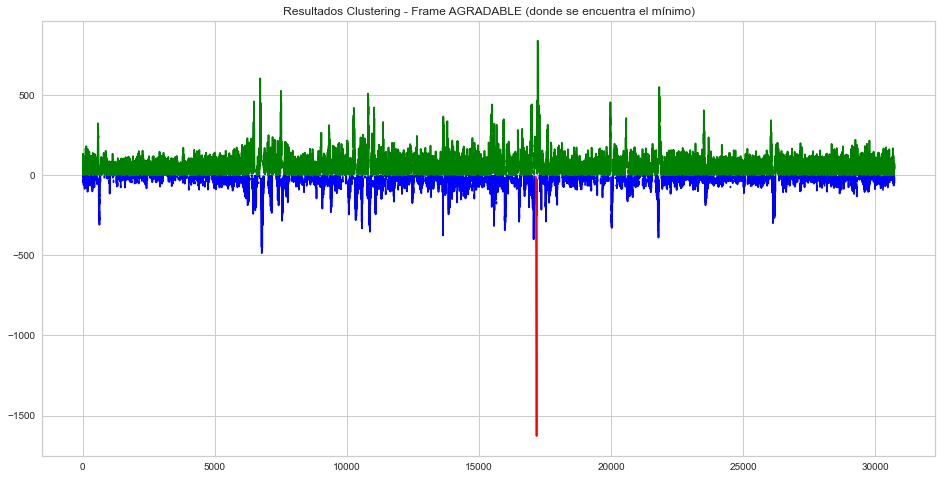

In [34]:
# Se genera un nuevo dataset que, para cada evento, contiene los registros intermedios
lst_eventos_splitted = []
for row in sc_df.itertuples():
    evento = [[i, row.cluster_id] for i in range(int(getattr(row, 'pos_ini')), int(getattr(row, 'pos_end')))]
    lst_eventos_splitted.extend(evento)

# Se agrega la información de evento al dataset original:
df_eventos_splitted = pd.DataFrame(data=lst_eventos_splitted, columns=['idx', 'cluster_id']).set_index(keys='idx', drop=True)
df_merge_sc = signals.merge(df_eventos_splitted, how='left', left_index=True, right_index=True)
df_merge_sc.cluster_id.fillna(99, inplace=True)
print(df_merge_sc.cluster_id.unique())

# https://community.dataquest.io/t/how-to-change-colour-of-a-line-plot-based-on-a-condition-below-above-average/558563/3
# Se grafica una porción de los datos
pos_ini = ini_agradable
pos_end = ini_blinks
df_graph = df_merge_sc[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,8))
plt.plot(np.where(df_graph.cluster_id == 0, df_graph.eeg, None), color="blue", label="1")
plt.plot(np.where(df_graph.cluster_id == 1, df_graph.eeg, None), color="red", label="1")
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label="1")
plt.title('Resultados Clustering - Frame AGRADABLE (donde se encuentra el mínimo)')
plt.show()

#### DBSCAN
Este algoritmo presenta buen Silhouette y separa los datos en 8 clusters.<br>
_**Conclusión**_: con estos hiperparámetros, el algoritmo DBSCAN presenta mejor _clusterización que el Spectral_, pero aún NO organiza los datos según la necesidad del estudio.

In [35]:
algorithm = 'dbscan'
dbscan = create_model(algorithm)
dbscan_df = assign_model(dbscan)
label_encoder = LabelEncoder()
dbscan_df['cluster_id'] = label_encoder.fit_transform(dbscan_df.Cluster)

Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  Rand Index  \
0      0.7569          4433.3677          3.7957            0           0   

   Completeness  
0             0

In [43]:
# darksalmon, darkseagreen, ghostwhite, gold, goldenrod, gray,lightskyblue, lightslategray, silver, skyblue, royalblue, aqua
# saddlebrown, salmon, sandybrown, 'mediumslateblue', mediumaquamarine
colors = ['darksalmon',  'royalblue', 'aquamarine', 'darkturquoise', 'magenta', 'maroon', 'lightslategray', 'sienna']
pie=dbscan_df.groupby('cluster_id').size().reset_index()
pie.columns=['cluster_id','value']
px.pie(pie, values='value', names='cluster_id'
    , color=colors
    , width=400, height=550
    , title='% Registros por Cluster')

#### En los siguientes gráficos se puede apreciar que el algoritmo logra separar respiraciones asignándolas a los clusters 0 y 3. 
#### También identifica casi sin error los períodos por debajo de 0 que no representan un evento (cluster 1)
#### Sin embargo, aún falta tuning porque confunde respiraciones con blinks (cluster 2), esta confusión se dá con más frecuencia en la zona de respiración rápida.

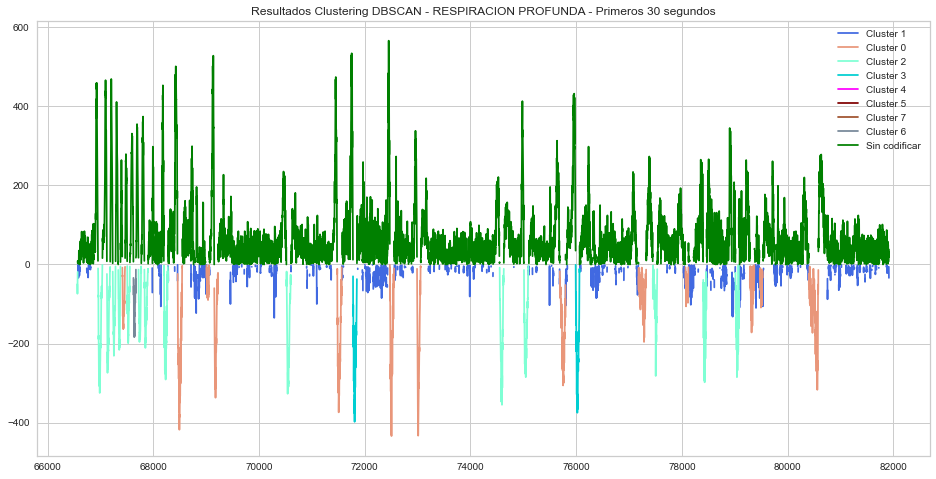

In [46]:
lst_eventos_splitted = []
for row in dbscan_df.itertuples():
    evento = [[i, row.cluster_id] for i in range(int(getattr(row, 'pos_ini')), int(getattr(row, 'pos_end')))]
    lst_eventos_splitted.extend(evento)

# Se agrega la información de evento al dataset original:
df_eventos_splitted = pd.DataFrame(data=lst_eventos_splitted, columns=['idx', 'cluster_id']).set_index(keys='idx', drop=True)
df_merge_dbscan = signals.merge(df_eventos_splitted, how='left', left_index=True, right_index=True)
df_merge_dbscan.cluster_id.fillna(99, inplace=True)

# Se grafica una porción de los datos
pos_ini = ini_hondo
pos_end = pos_ini + (512*30)
df_graph = df_merge_dbscan[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,8))
for i in df_merge_dbscan.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering DBSCAN - RESPIRACION PROFUNDA - Primeros 30 segundos')
plt.show()

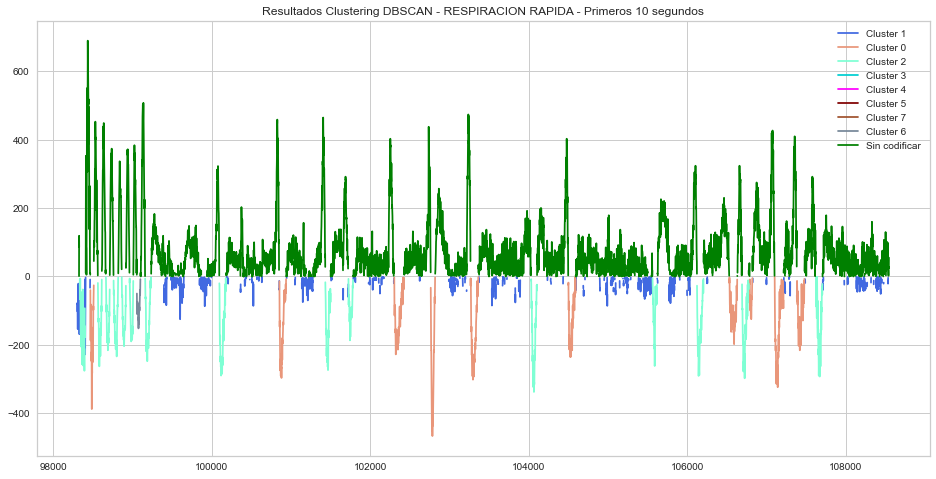

In [45]:
# Se grafica una porción de los datos
pos_ini = ini_rapido
pos_end = pos_ini + (512*20)
df_graph = df_merge_dbscan[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,8))
for i in df_merge_dbscan.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering DBSCAN - RESPIRACION RAPIDA - Primeros 10 segundos')
plt.show()

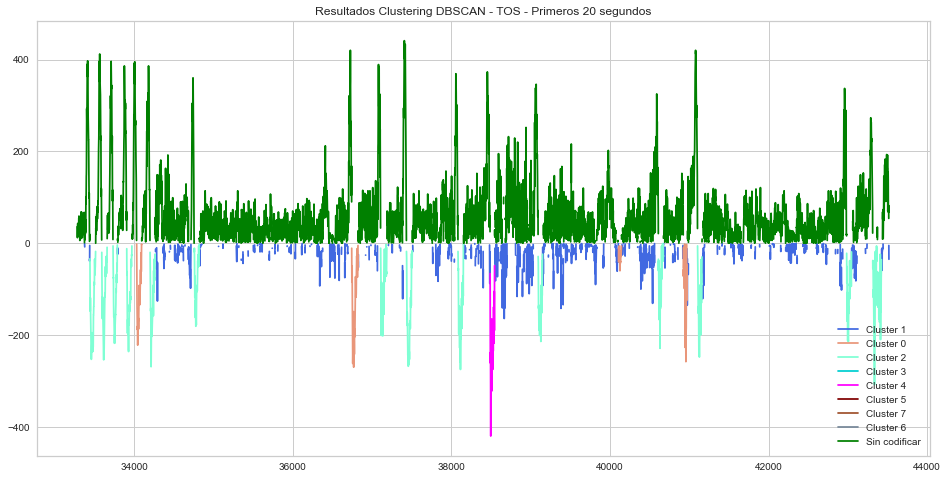

In [48]:
# Se grafica una porción de los datos
pos_ini = ini_tos
pos_end = pos_ini + (512*20)
df_graph = df_merge_dbscan[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,8))
for i in df_merge_dbscan.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering DBSCAN - TOS - Primeros 20 segundos')
plt.show()

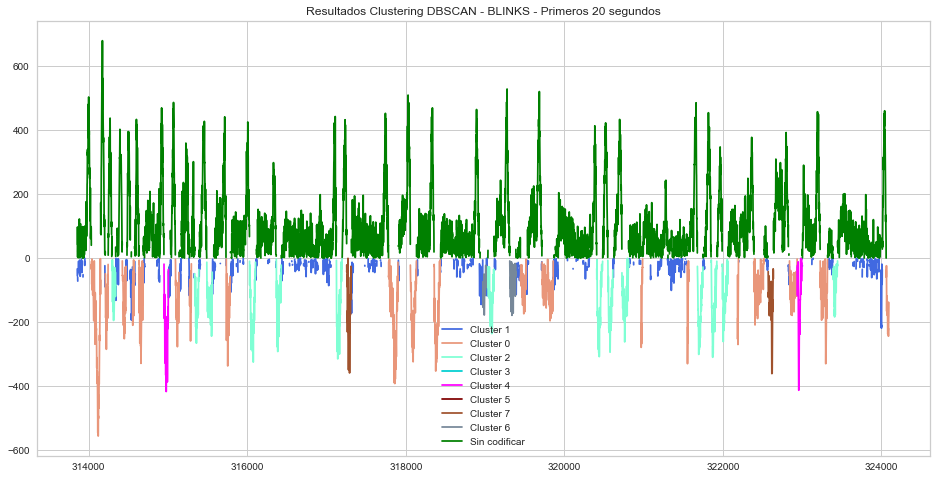

In [49]:
# Se grafica una porción de los datos
pos_ini = ini_blinks
pos_end = pos_ini + (512*20)
df_graph = df_merge_dbscan[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,8))
for i in df_merge_dbscan.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering DBSCAN - BLINKS - Primeros 20 segundos')
plt.show()

#### birch
Este algoritmo presenta buen Silhouette y separa los datos en 4 clusters.<br>
_**Conclusión**_: con estos hiperparámetros, el algoritmo birch presenta buena clusterización, pero aún NO organiza los datos según la necesidad del estudio.

In [50]:
algorithm = 'birch'
birch = create_model(algorithm)
birch_df = assign_model(birch)
label_encoder = LabelEncoder()
birch_df['cluster_id'] = label_encoder.fit_transform(birch_df.Cluster)

Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  Rand Index  \
0       0.883          7860.3523          0.4759            0           0   

   Completeness  
0             0

In [53]:
# darksalmon, darkseagreen, ghostwhite, gold, goldenrod, gray,lightskyblue, lightslategray, silver, skyblue, royalblue, aqua
# saddlebrown, salmon, sandybrown, 'mediumslateblue', mediumaquamarine
colors = ['darksalmon',  'royalblue', 'aquamarine', 'magenta', 'maroon', 'lightslategray', 'sienna', 'darkturquoise']
pie=birch_df.groupby('cluster_id').size().reset_index()
pie.columns=['cluster_id','value']
px.pie(pie, values='value', names='cluster_id'
    , color=colors[:4]
    , width=400, height=550
    , title='% Registros por Cluster')

#### En los siguientes gráficos se aprecia que el algoritmo logra separar respiraciones asignándolas al clusters 3. No diferencia entre profunda y rápida, pero las diferencia bastante bien de los blinks iniciales de cada fase del protocolo.
#### Sin embargo, en la fase de blinking asigna a al cluster 3 eventos que son blinks. Lo mismo en la fase tos.

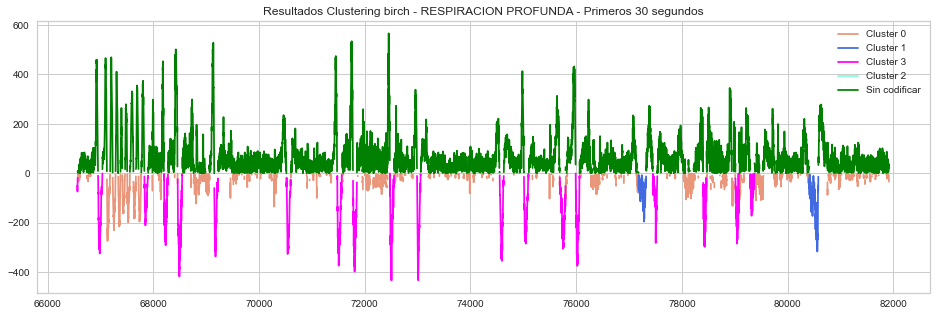

In [57]:
lst_eventos_splitted = []
for row in birch_df.itertuples():
    evento = [[i, row.cluster_id] for i in range(int(getattr(row, 'pos_ini')), int(getattr(row, 'pos_end')))]
    lst_eventos_splitted.extend(evento)

# Se agrega la información de evento al dataset original:
df_eventos_splitted = pd.DataFrame(data=lst_eventos_splitted, columns=['idx', 'cluster_id']).set_index(keys='idx', drop=True)
df_merge_birch = signals.merge(df_eventos_splitted, how='left', left_index=True, right_index=True)
df_merge_birch.cluster_id.fillna(99, inplace=True)

# Se grafica una porción de los datos
pos_ini = ini_hondo
pos_end = pos_ini + (512*30)
df_graph = df_merge_birch[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,5))
for i in df_merge_birch.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering birch - RESPIRACION PROFUNDA - Primeros 30 segundos')
plt.show()

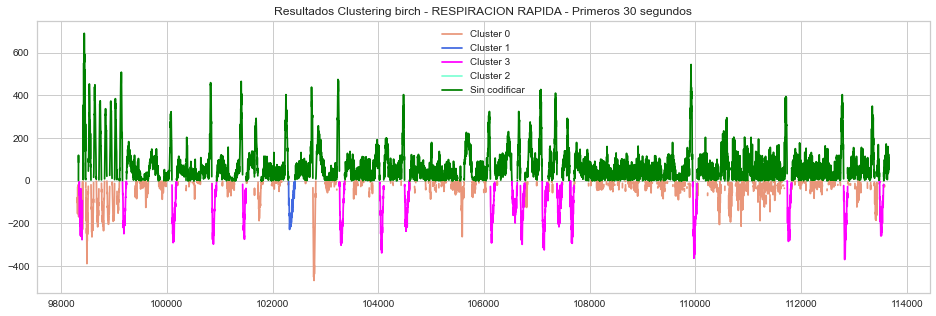

In [58]:
# Se grafica una porción de los datos
pos_ini = ini_rapido
pos_end = pos_ini + (512*30)
df_graph = df_merge_birch[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,5))
for i in df_merge_birch.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering birch - RESPIRACION RAPIDA - Primeros 30 segundos')
plt.show()

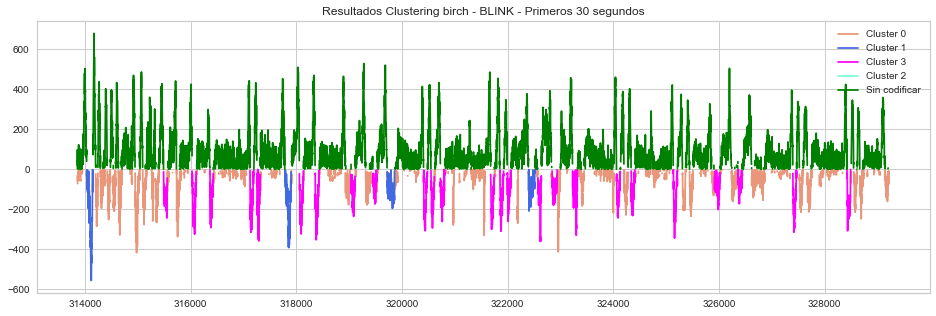

In [59]:
# Se grafica una porción de los datos
pos_ini = ini_blinks
pos_end = pos_ini + (512*30)
df_graph = df_merge_birch[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,5))
for i in df_merge_birch.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering birch - BLINK - Primeros 30 segundos')
plt.show()

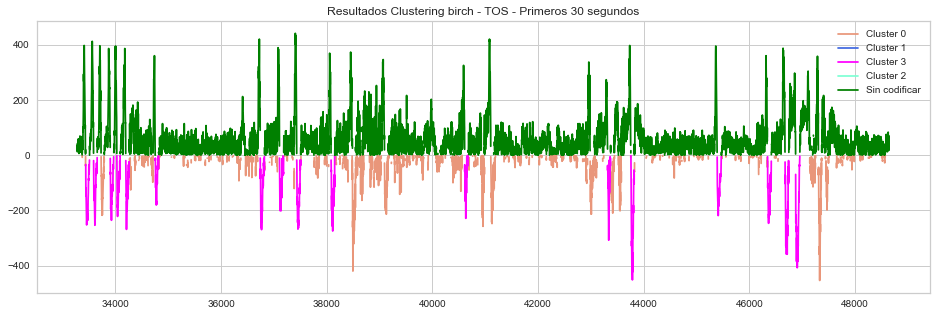

In [60]:
# Se grafica una porción de los datos
pos_ini = ini_tos
pos_end = pos_ini + (512*30)
df_graph = df_merge_birch[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,5))
for i in df_merge_birch.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering birch - TOS - Primeros 30 segundos')
plt.show()

#### Agglomerative Clustering
Este algoritmo presenta buen Silhouette y separa los datos en 4 clusters.<br>
_**Conclusión**_: con estos hiperparámetros, el algoritmo birch presenta buena clusterización, pero aún NO organiza los datos según la necesidad del estudio.

In [61]:
# Se buscó ver si con otra cantidad de clusters se consigue mejores indicadores:
##### Agglomerative Clustering con cambios en los hiperparámetros
X=df_eventos.drop(['ts_ini', 'ts_end', 'pos_ini', 'pos_end', 'frame', 'frame_id'], axis=1)
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=3, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
algorithm = 'hclust'
hclust = create_model(algorithm, linkage="average", affinity="cityblock", connectivity=connectivity)
hclust_df = assign_model(hclust)
label_encoder = LabelEncoder()
hclust_df['cluster_id'] = label_encoder.fit_transform(hclust_df.Cluster)

Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  Rand Index  \
0      0.9062           342.8782          0.2343            0           0   

   Completeness  
0             0

In [62]:
# darksalmon, darkseagreen, ghostwhite, gold, goldenrod, gray,lightskyblue, lightslategray, silver, skyblue, royalblue, aqua
# saddlebrown, salmon, sandybrown, 'mediumslateblue', mediumaquamarine
colors = ['darksalmon',  'royalblue', 'aquamarine', 'magenta', 'maroon', 'lightslategray', 'sienna', 'darkturquoise']
pie=hclust_df.groupby('cluster_id').size().reset_index()
pie.columns=['cluster_id','value']
px.pie(pie, values='value', names='cluster_id'
    , color=colors[:4]
    , width=400, height=550
    , title='% Registros por Cluster')

#### En los siguientes gráficos se aprecia que el algoritmo no logra separar eventos en forma significativa.

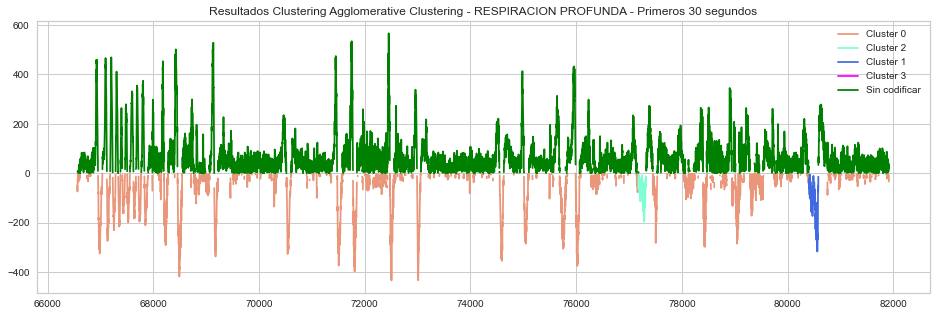

In [66]:
lst_eventos_splitted = []
for row in hclust_df.itertuples():
    evento = [[i, row.cluster_id] for i in range(int(getattr(row, 'pos_ini')), int(getattr(row, 'pos_end')))]
    lst_eventos_splitted.extend(evento)

# Se agrega la información de evento al dataset original:
df_eventos_splitted = pd.DataFrame(data=lst_eventos_splitted, columns=['idx', 'cluster_id']).set_index(keys='idx', drop=True)
df_merge_hclust = signals.merge(df_eventos_splitted, how='left', left_index=True, right_index=True)
df_merge_hclust.cluster_id.fillna(99, inplace=True)

# Se grafica una porción de los datos
pos_ini = ini_hondo
pos_end = pos_ini + (512*30)
df_graph = df_merge_hclust[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,5))
for i in df_merge_hclust.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering Agglomerative - RESPIRACION PROFUNDA - Primeros 30 segundos')
plt.show()

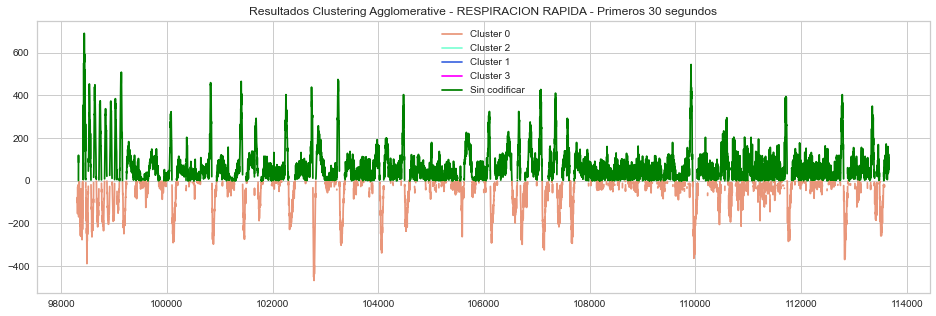

In [67]:
# Se grafica una porción de los datos
pos_ini = ini_rapido
pos_end = pos_ini + (512*30)
df_graph = df_merge_hclust[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,5))
for i in df_merge_hclust.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering Agglomerative - RESPIRACION RAPIDA - Primeros 30 segundos')
plt.show()

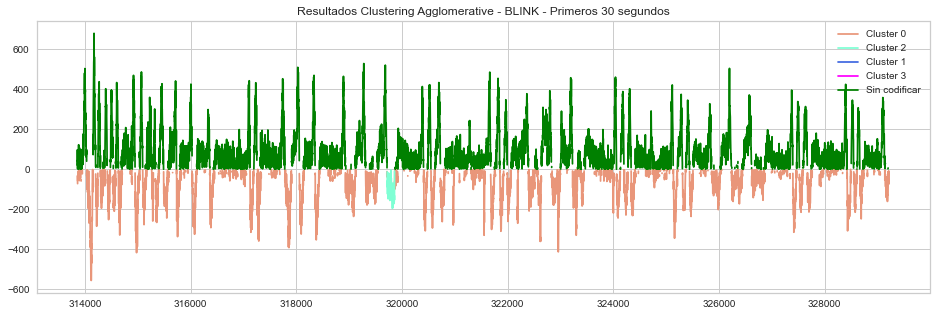

In [69]:
# Se grafica una porción de los datos
pos_ini = ini_blinks
pos_end = pos_ini + (512*30)
df_graph = df_merge_hclust[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,5))
for i in df_merge_hclust.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering Agglomerative - BLINK - Primeros 30 segundos')
plt.show()

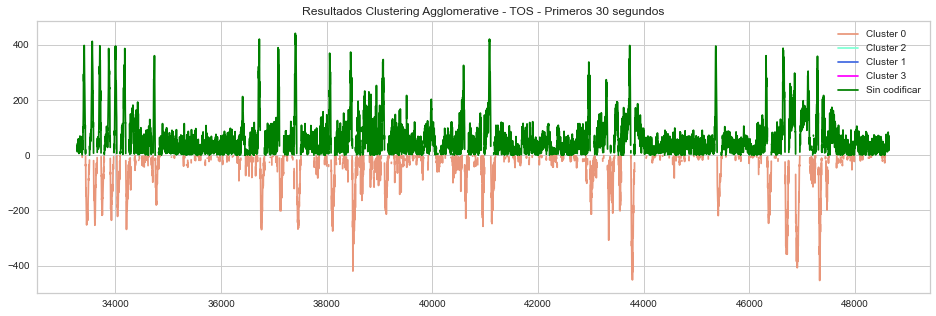

In [68]:
# Se grafica una porción de los datos
pos_ini = ini_tos
pos_end = pos_ini + (512*30)
df_graph = df_merge_hclust[pos_ini: pos_end]

fig, ax = plt.subplots(figsize=(16,5))
for i in df_merge_hclust.cluster_id.unique()[1:]:
    plt.plot(np.where(df_graph.cluster_id == i, df_graph.index, None)
            , np.where(df_graph.cluster_id == i, df_graph.eeg, None), color=colors[int(i)], label='Cluster ' + str(int(i)))
plt.plot(np.where(df_graph.cluster_id == 99, df_graph.index, None)
        , np.where(df_graph.cluster_id == 99, df_graph.eeg, None), color="green", label='Sin codificar')
plt.legend()
plt.title('Resultados Clustering Agglomerative - TOS - Primeros 30 segundos')
plt.show()

### Estudios Adicionales
Se hizo un ejercicio de cálculo de threshold con el objetivo de intentar incluir estos valores en la caracterización de los semi-eventos o para filtrar semi-eventos.

Pero no alcanzó el tiempo para probarlo.

In [ ]:
lst_ini_frames = [ini_start, ini_baseline, ini_tos, ini_hondo, ini_rapido, ini_cuenta, ini_violeta, ini_rojo, ini_sonreir, ini_desagradable
                , ini_agradable, ini_blinks]

lst_frames_name = ['START', 'BASELINE', 'TOS', 'HONDO', 'RAPIDO', 'CUENTA MENTAL', 'COLORES VIOLETA', 'COLORES ROJO', 'SONREIR', 'DESEGRADABLE'
                , 'AGRADABLE', 'BLINKING']

In [ ]:
import scipy
from scipy import stats
import seaborn as sns

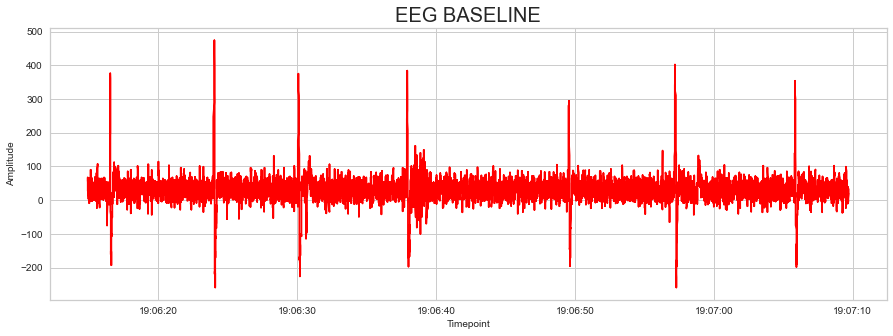

normality = NormaltestResult(statistic=11716.255703550723, pvalue=0.0)


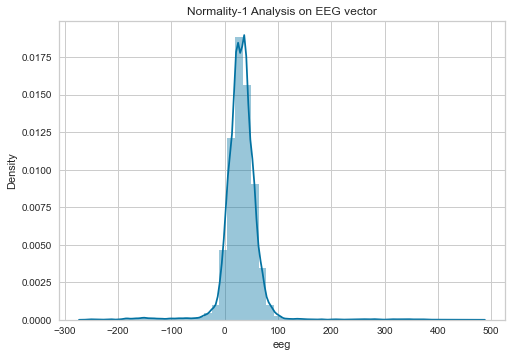

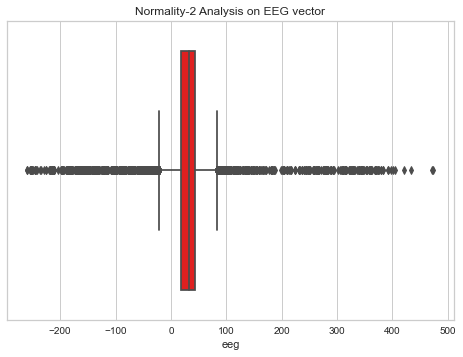

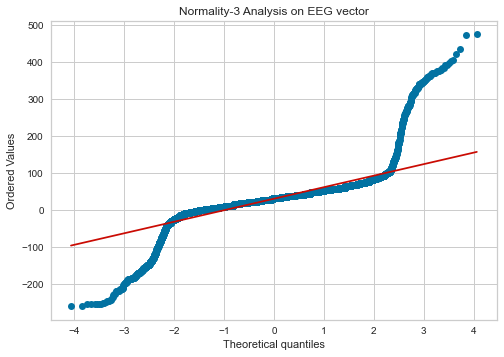

In [ ]:
# El gráfico con la totalidad de los eventos registrados indica 2 clusters. 
# Una cantidad muy pequeña para la cantidad de distintos eventos que se registraron.
# --> Se filtran los eventos con duración significativa.
df_eventos[df_eventos.pos_ini.between(ini_baseline, ini_tos)].describe()
# Gráfica en hertz
ini_baseline = end_start
end_baseline = ini_baseline + (512*55)

df_frame = signals[ini_baseline:end_baseline]
plt.figure(figsize=(15,5))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG BASELINE",size=20)
plt.show()

# Prueba de normalidad
print('normality = {}'.format(scipy.stats.normaltest(df_frame.eeg)))
sns.distplot(df_frame.eeg)
plt.title("Normality-1 Analysis on EEG vector")
plt.show()
sns.boxplot(df_frame.eeg, color="red")
plt.title("Normality-2 Analysis on EEG vector")
plt.show()
res = stats.probplot(df_frame.eeg, plot = plt)
plt.title("Normality-3 Analysis on EEG vector") 
plt.show()


Upper Threshold: 142
Lower Threshold: -80


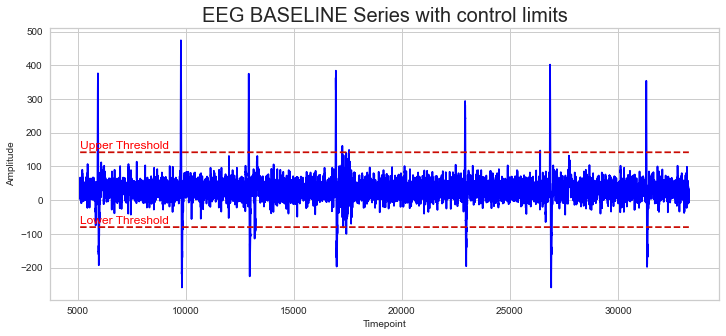

In [ ]:
#Find the threshold values to determine what is a blinking and what is not
umbral_superior=int(df_frame.eeg.mean()+3*df_frame.eeg.std())
print("Upper Threshold: {}".format(umbral_superior))
umbral_inferior=int(df_frame.eeg.mean()-3*df_frame.eeg.std())
print("Lower Threshold: {}".format(umbral_inferior))
plt.figure(figsize=(12,5))
plt.plot(df_frame.eeg,color="blue")
plt.plot(df_frame.index, np.full(len(df_frame.eeg),umbral_superior),'r--')
plt.plot(df_frame.index, np.full(len(df_frame.eeg),umbral_inferior),'r--')
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG BASELINE Series with control limits",size=20)
plt.annotate("Upper Threshold",xy=(df_frame.index.min(),umbral_superior+10),color="red")
plt.annotate("Lower Threshold",xy=(df_frame.index.min(),umbral_inferior+10),color="red")
plt.show()


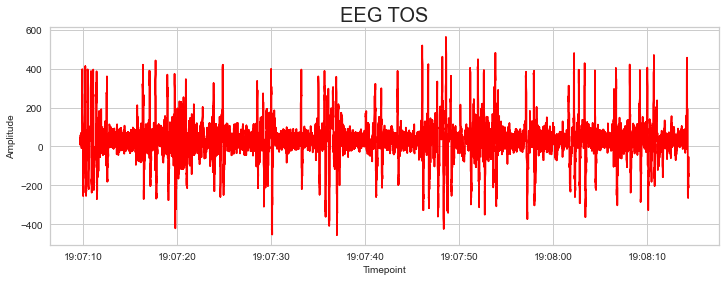

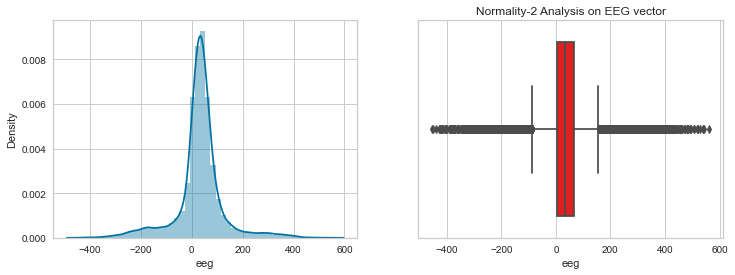

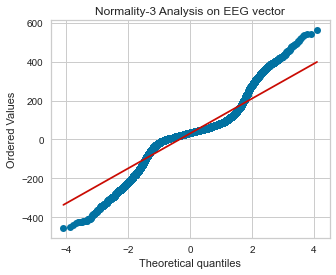

In [ ]:
# TOS
ini = ini_tos
end = ini_hondo

df_frame = signals[ini:end]
plt.figure(figsize=(12, 4))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG TOS",size=20)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(df_frame.eeg, ax=axes[0])
plt.title("Normality-1 Analysis on EEG vector")
sns.boxplot(df_frame.eeg, color="red", ax=axes[1]);
plt.title("Normality-2 Analysis on EEG vector")
plt.figure(figsize=(5,4))
res = stats.probplot(df_frame.eeg, plot = plt);
plt.title("Normality-3 Analysis on EEG vector")
plt.show()

Upper Threshold: 318
Lower Threshold: -256


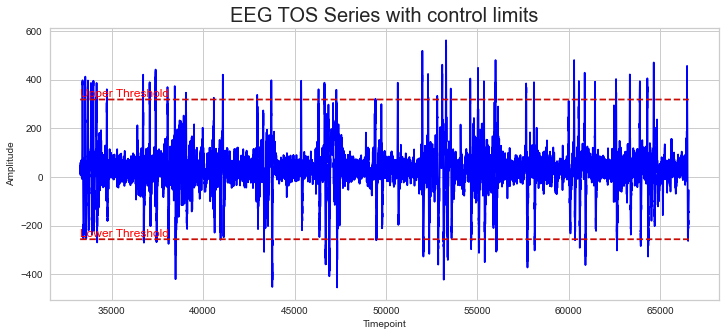

In [ ]:
#Find the threshold values to determine events
umbral_superior=int(df_frame.eeg.mean()+3*df_frame.eeg.std())
print("Upper Threshold: {}".format(umbral_superior))
umbral_inferior=int(df_frame.eeg.mean()-3*df_frame.eeg.std())
print("Lower Threshold: {}".format(umbral_inferior))
plt.figure(figsize=(12,5))
plt.plot(df_frame.eeg,color="blue")
plt.plot(df_frame.index, np.full(len(df_frame.eeg),umbral_superior),'r--')
plt.plot(df_frame.index, np.full(len(df_frame.eeg),umbral_inferior),'r--')
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG TOS Series with control limits",size=20)
plt.annotate("Upper Threshold",xy=(df_frame.index.min(),umbral_superior+10),color="red")
plt.annotate("Lower Threshold",xy=(df_frame.index.min(),umbral_inferior+10),color="red")
plt.show()


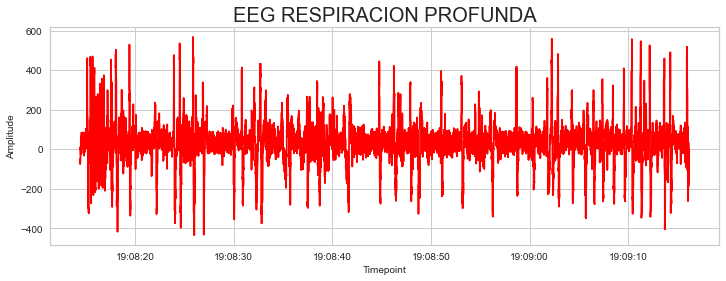

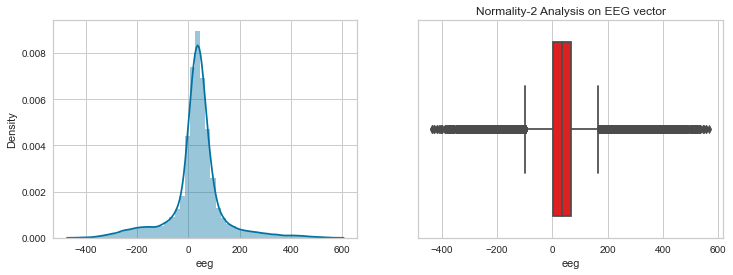

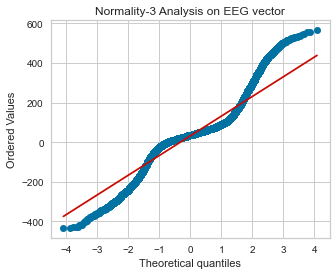

In [ ]:
# RESPIRACION HONDA
ini = ini_hondo
end = ini_rapido

df_frame = signals[ini:end]
plt.figure(figsize=(12, 4))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG RESPIRACION PROFUNDA",size=20)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(df_frame.eeg, ax=axes[0])
plt.title("Normality-1 Analysis on EEG vector")
sns.boxplot(df_frame.eeg, color="red", ax=axes[1]);
plt.title("Normality-2 Analysis on EEG vector")
plt.figure(figsize=(5,4))
res = stats.probplot(df_frame.eeg, plot = plt);
plt.title("Normality-3 Analysis on EEG vector")
plt.show()

Upper Threshold: 350
Lower Threshold: -287


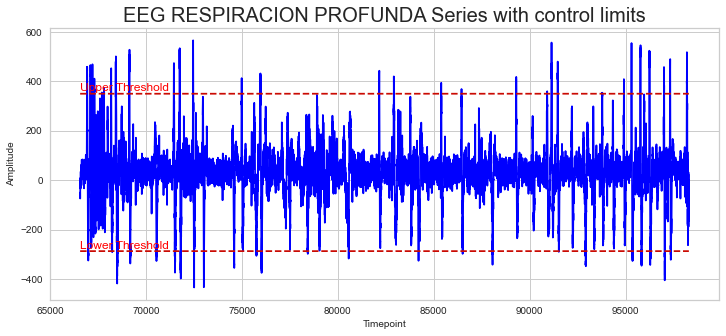

In [ ]:
#Find the threshold values to determine events
umbral_superior=int(df_frame.eeg.mean()+3*df_frame.eeg.std())
print("Upper Threshold: {}".format(umbral_superior))
umbral_inferior=int(df_frame.eeg.mean()-3*df_frame.eeg.std())
print("Lower Threshold: {}".format(umbral_inferior))
plt.figure(figsize=(12,5))
plt.plot(df_frame.eeg,color="blue")
plt.plot(df_frame.index, np.full(len(df_frame.eeg),umbral_superior),'r--')
plt.plot(df_frame.index, np.full(len(df_frame.eeg),umbral_inferior),'r--')
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG RESPIRACION PROFUNDA Series with control limits",size=20)
plt.annotate("Upper Threshold",xy=(df_frame.index.min(),umbral_superior+10),color="red")
plt.annotate("Lower Threshold",xy=(df_frame.index.min(),umbral_inferior+10),color="red")
plt.show()

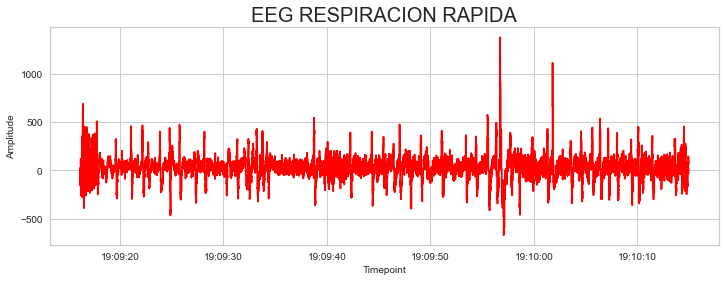

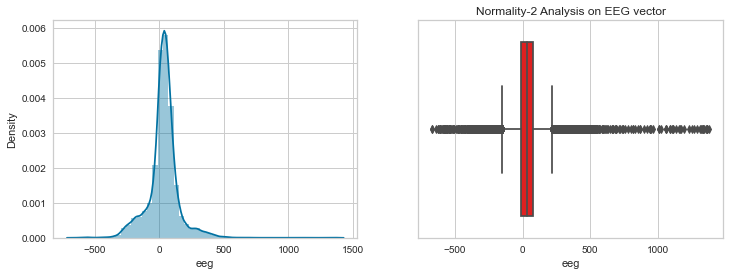

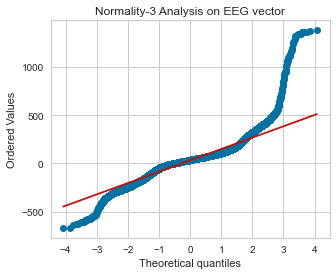

In [ ]:
# RESPIRACION RAPIDA
ini = ini_rapido
end = ini_cuenta

df_frame = signals[ini:end]
plt.figure(figsize=(12, 4))
plt.plot(df_frame.time, df_frame.eeg, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG RESPIRACION RAPIDA",size=20)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(df_frame.eeg, ax=axes[0])
plt.title("Normality-1 Analysis on EEG vector")
sns.boxplot(df_frame.eeg, color="red", ax=axes[1]);
plt.title("Normality-2 Analysis on EEG vector")
plt.figure(figsize=(5,4))
res = stats.probplot(df_frame.eeg, plot = plt);
plt.title("Normality-3 Analysis on EEG vector")
plt.show()

Upper Threshold: 407
Lower Threshold: -345


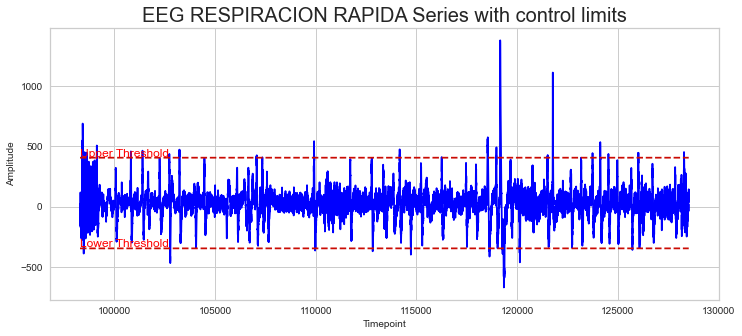

In [ ]:
#Find the threshold values to determine events
umbral_superior=int(df_frame.eeg.mean()+3*df_frame.eeg.std())
print("Upper Threshold: {}".format(umbral_superior))
umbral_inferior=int(df_frame.eeg.mean()-3*df_frame.eeg.std())
print("Lower Threshold: {}".format(umbral_inferior))
plt.figure(figsize=(12,5))
plt.plot(df_frame.eeg,color="blue")
plt.plot(df_frame.index, np.full(len(df_frame.eeg),umbral_superior),'r--')
plt.plot(df_frame.index, np.full(len(df_frame.eeg),umbral_inferior),'r--')
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG RESPIRACION RAPIDA Series with control limits",size=20)
plt.annotate("Upper Threshold",xy=(df_frame.index.min(),umbral_superior+10),color="red")
plt.annotate("Lower Threshold",xy=(df_frame.index.min(),umbral_inferior+10),color="red")
plt.show()

# FIN

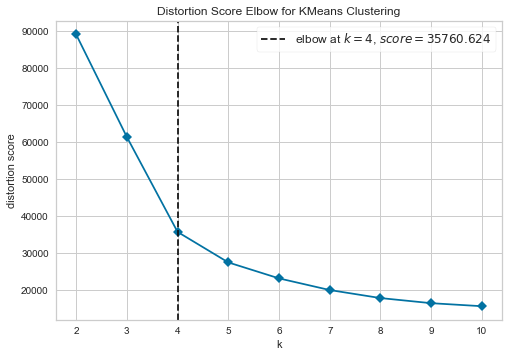

In [ ]:
plot_model(model, plot='elbow')

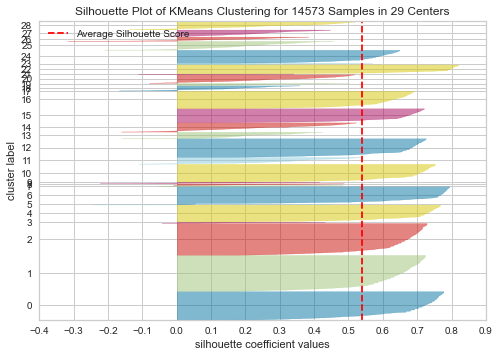

In [ ]:
plot_model(model, plot='silhouette'  )

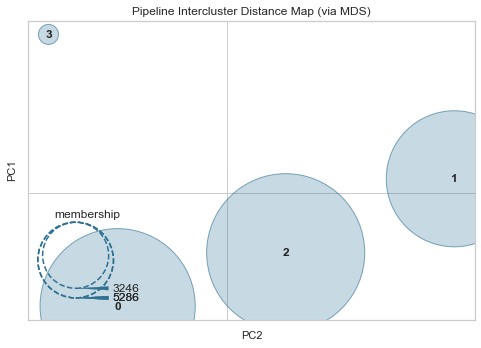

In [ ]:
plot_model(kmeans, plot='distance')

In [ ]:
kmeans_df = assign_model(model)
kmeans_df.head()
label_encoder = LabelEncoder()
kmeans_df['cluster_id'] = label_encoder.fit_transform(kmeans_df.Cluster)
kmeans_df.head()

ts_ini        ts_end  pos_ini  pos_end  bits  eeg_min  frame  \
0  1.655925e+09  1.655925e+09      116      119     3       -8  START   
1  1.655925e+09  1.655925e+09      122      125     3      -10  START   
2  1.655925e+09  1.655925e+09      155      156     1       -3  START   
3  1.655925e+09  1.655925e+09      179      181     2       -3  START   
4  1.655925e+09  1.655925e+09      215      221     6       -9  START   

   duration  frame_id    Cluster  cluster_id  
0      0.00        10  Cluster 6          25  
1      0.00        10  Cluster 6          25  
2      0.00        10  Cluster 6          25  
3      0.00        10  Cluster 6          25  
4      0.01        10  Cluster 6          25

In [ ]:
fig1 = px.scatter(kmeans_df, x="eeg_min", y="bits", color="Cluster",
                 size="duration")
fig1.update_layout(title="4 Features Representation - Frame = color - Duration = size of bubble - Detail")
fig1.update_xaxes(range=[-600, 0])
#fig1.update_yaxes(range=[3, 9])
fig1.show()

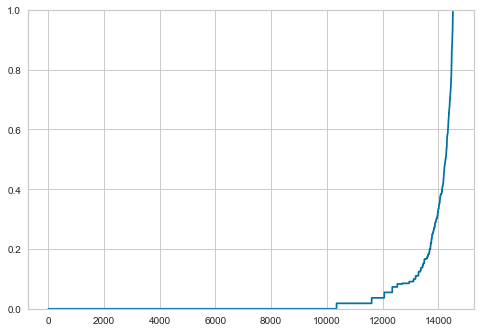

In [ ]:
# Estimación de eps para dbscan, según regla del codo:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim(0, 1);

## Clustering with sklearn
https://towardsdatascience.com/clustering-with-more-than-two-features-try-this-to-explain-your-findings-b053007d680a